# LOAD PYTHON PACKAGES

In [240]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [241]:
!pip install indic-nlp-library

In [242]:
!pip install punjabi_stopwords

In [243]:
!pip install LiHiSTO

In [244]:
!pip install emoji

In [245]:
!pip install wordcloud

In [246]:
!pip install punjabi_stopwords

In [247]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
from indicnlp.tokenize import indic_tokenize
from punjabi_stopwords import remove_stopwords
from stopwords_hindi import hindi_sw
import emoji
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler

# LOAD DATA INTO MEMORY

In [248]:
tweets_file_name = 'farmers-protest-tweets.json'

tweets_set = []
with open(tweets_file_name, 'r') as file:
    for line in file:
        try:
            tweet = json.loads(line)
            tweets_set.append(tweet)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

print(f"Successfully loaded {len(tweets_set)} tweets.")

Successfully loaded 117407 tweets.


In [249]:
language_count = {}

for tweet in tweets_set:
    lang = tweet.get('lang', 'unknown')  # Obtaining the language "unkown" in case it does not exist
    if lang in language_count:
        language_count[lang] += 1  # Increment de language count in case it is already in the dictionary
    else:
        language_count[lang] = 1  # Initialize the key in the dictionary
sorted_language_count = sorted(language_count.items(), key=lambda item: item[1], reverse=True)

for lang, count in sorted_language_count:
    print(f"{lang}: {count} tweets")


en: 48429 tweets
und: 35372 tweets
hi: 17880 tweets
pa: 10028 tweets
in: 1823 tweets
tl: 527 tweets
et: 524 tweets
ta: 451 tweets
kn: 265 tweets
ht: 222 tweets
mr: 187 tweets
es: 176 tweets
ur: 131 tweets
gu: 126 tweets
ml: 110 tweets
te: 103 tweets
fr: 92 tweets
tr: 86 tweets
it: 73 tweets
bn: 73 tweets
pt: 69 tweets
da: 64 tweets
hu: 60 tweets
de: 58 tweets
fi: 54 tweets
ne: 50 tweets
nl: 44 tweets
sl: 39 tweets
ca: 35 tweets
ro: 32 tweets
sv: 31 tweets
eu: 30 tweets
lv: 30 tweets
cy: 25 tweets
no: 22 tweets
cs: 21 tweets
or: 18 tweets
lt: 14 tweets
pl: 11 tweets
is: 7 tweets
vi: 5 tweets
ja: 4 tweets
ru: 3 tweets
ar: 1 tweets
fa: 1 tweets
si: 1 tweets


# PART 1

## PREPROCESS THE DOCUMENT

Removing stop words
● Tokenization
● Removing punctuation marks
● Stemming
● and... anything else you think it's needed (bonus point)

In [250]:
def remove_emojis(text):
    return emoji.replace_emoji(text, "")


In [251]:
def combine_hashtags(tokens):
    combined_tokens = []
    i = 0

    while i < len(tokens):
        if tokens[i].startswith('#') and i + 1 < len(tokens):
            # Combines de # with the next token
            combined_tokens.append(f"{tokens[i]}{tokens[i + 1]}")
            i += 2
        else:
            combined_tokens.append(tokens[i])
            i += 1

    return combined_tokens

In [252]:
def combine_at(tokens):  #The same code as before but with the @ of the users
  combined_at = []
  i=0

  while i < len(tokens):
    if tokens[i].startswith('@') and i + 1 < len(tokens):
      combined_at.append(f"{tokens[i]}{tokens[i+1]}")
      i += 2
    else:
      combined_at.append(tokens[i])
      i += 1

  return combined_at

In [253]:
def remove_punctuation_mixed(tokens):
    punctuation_list = [',','-','.','|','!','?','!!',':','...','=','/', ';', '(', ')', "'", "।"]
    punct_pattern = r"^[{}]+|[{}]+$".format(re.escape(''.join(punctuation_list)), re.escape(''.join(punctuation_list)))
    cleaned_tokens = []

    for token in tokens:
        # Remove punctuation using regex
        cleaned_token = re.sub(punct_pattern, '', token)
        # Add the cleaned token
        cleaned_tokens.append(cleaned_token)

    return cleaned_tokens

In [254]:
stop_words_english = set(stopwords.words('english'))
stop_words_indonesian = set(stopwords.words('indonesian'))
stop_words_hindi = hindi_sw.get_hindi_sw()

from punjabi_stopwords import remove_stopwords  # Import your stopwords removal function

def build_terms(tweet):
    """
    Preprocess the tweet text (removing stop words, stemming,
    transforming to lowercase and returning the tokens).

    Arguments:
    tweet -- dictionary containing 'content' (text) and 'lang' (language)

    Returns:
    tokens - a list of tokens corresponding to the input text after preprocessing
    """

    line = tweet['content']
    lang = tweet['lang']

    stemmer = PorterStemmer()

    # Transform to lowercase
    line = line.lower()
    line = remove_emojis(line) #additionally we decided to also remove emojis from the text, since they are not relevant for the search
    line = re.sub(r"'", '', line)

    line = re.sub(r'https://[^\s]+', '', line)

    # Tokenize based on the language
    if lang in ['pa', 'hi']:  # Hindi and Punjabi
        tokens = indic_tokenize.trivial_tokenize(line)  # Tokenize for Punjabi
        tokens = combine_hashtags(tokens)
        tokens = combine_at(tokens)
    else:  # English and Indonesian
        tokens = line.split()

    tokens = remove_punctuation_mixed(tokens)


    # Remove stopwords based on language
    if lang == 'en':
        tokens = [x for x in tokens if x not in stop_words_english]
    elif lang == 'id':
        tokens = [x for x in tokens if x not in stop_words_indonesian]
    elif lang == 'hi':
        tokens = [x for x in tokens if x not in stop_words_hindi]
    elif lang == 'pa':
        # Join tokens into a single string for stopword removal
        text_string = ' '.join(tokens)
        filtered_text = remove_stopwords(text_string)  # Remove stopwords
        tokens = filtered_text.split()

    tokens = [x for x in tokens if x not in [',','-','.','|','!','?','!!',':','...','=','/', ';', '(', ')', "'", "।", '\n', '', '_', '"','&amp', '\n\n']] #extra layer of purification upon inspecting the most frequent tokens
    # Perform stemming
    tokens = [stemmer.stem(x) for x in tokens]

    return tokens


### PUNJABI EXAMPLE

In [255]:
tweets_set[2]

{'url': 'https://twitter.com/parmarmaninder/status/1364506195453767680',
 'date': '2021-02-24T09:23:22+00:00',
 'content': "ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇਰੇ ਹਿਸਾਬ ਨਾਲ ਬਾਹਰ(ਪ੍ਰਦੇਸ਼) ਜਾਣ ਨਾਲੋਂ ਬਿਹਤਰ ਆ ਭਾਰਤ 'ਚ ਪੈਟਰੋਲ ਪੰਪ ਪਾ ਲਈਏ। 🤫🤫🤔🤔\n#FarmersProtest",
 'renderedContent': "ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇਰੇ ਹਿਸਾਬ ਨਾਲ ਬਾਹਰ(ਪ੍ਰਦੇਸ਼) ਜਾਣ ਨਾਲੋਂ ਬਿਹਤਰ ਆ ਭਾਰਤ 'ਚ ਪੈਟਰੋਲ ਪੰਪ ਪਾ ਲਈਏ। 🤫🤫🤔🤔\n#FarmersProtest",
 'id': 1364506195453767680,
 'user': {'username': 'parmarmaninder',
  'displayname': 'maninder singh',
  'id': 476006247,
  'description': '।।ਨਾਨਕ ਨਾਮ ਚੜ੍ਹਦੀ ਕਲਾ ਤੇਰੈ ਭਾਣੈ ਸਰਬੱਤ ਦਾ ਭਲਾ।।',
  'rawDescription': '।।ਨਾਨਕ ਨਾਮ ਚੜ੍ਹਦੀ ਕਲਾ ਤੇਰੈ ਭਾਣੈ ਸਰਬੱਤ ਦਾ ਭਲਾ।।',
  'descriptionUrls': [],
  'verified': False,
  'created': '2012-01-27T17:30:27+00:00',
  'followersCount': 72,
  'friendsCount': 151,
  'statusesCount': 2285,
  'favouritesCount': 846,
  'listedCount': 0,
  'mediaCount': 265,
  'location': '',
  'protected': False,
  'linkUrl': None,
  'linkTcourl': None,
  'p

In [256]:
build_terms(tweets_set[2])

['ਪੈਟਰੋਲ',
 'ਕੀਮਤਾਂ',
 'ਮੱਦੇਨਜ਼ਰ',
 'ਰੱਖਦੇ',
 'ਮੇਰੇ',
 'ਹਿਸਾਬ',
 'ਬਾਹਰ',
 'ਪ੍ਰਦੇਸ਼',
 'ਜਾਣ',
 'ਨਾਲੋਂ',
 'ਬਿਹਤਰ',
 'ਭਾਰਤ',
 'ਚ',
 'ਪੈਟਰੋਲ',
 'ਪੰਪ',
 'ਪਾ',
 'ਲਈਏ',
 '#farmersprotest']

### ENGLISH EXAMPLE

In [257]:
tweets_set[0]

{'url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198',
 'date': '2021-02-24T09:23:35+00:00',
 'content': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF',
 'renderedContent': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur twitter.com/ravisinghka/st…',
 'id': 1364506249291784198,
 'user': {'username': 'ArjunSinghPanam',
  'displayname': 'Arjun Singh Panam',
  'id': 45091142,
  'description': 'Global Citizen, Actor, Director: Sky is the roof above my head, the world is the road I travel, love is my food & mother earth is my bed. Roy in @CosmosMovie',
  'rawDescription':

In [258]:
build_terms(tweets_set[0])

['world',
 'progress',
 'indian',
 'polic',
 'govt',
 'still',
 'tri',
 'take',
 'india',
 'back',
 'horrif',
 'past',
 'tyranni',
 '@narendramodi',
 '@delhipolic',
 'shame',
 '#modidontsellfarm',
 '#farmersprotest',
 '#freenodeepkaur']

### INDONESIAN EXAMPLE

In [259]:
count=0
i=0
for tweet in tweets_set:
    if tweet['lang'] == 'in':
        count = i
        break
    i += 1
print(count)


139


In [260]:
tweets_set[139]

{'url': 'https://twitter.com/SandeepLakha11/status/1364499171831549953',
 'date': '2021-02-24T08:55:28+00:00',
 'content': '@GoluBha42573817 @pinkichaubey Toh salayeo ehnke liye hi kuch krlo agar yeh b sadko pr aa gye fir tum log modi bhagti hi kroge  . Andh bhgto  #FarmersProtest',
 'renderedContent': '@GoluBha42573817 @pinkichaubey Toh salayeo ehnke liye hi kuch krlo agar yeh b sadko pr aa gye fir tum log modi bhagti hi kroge  . Andh bhgto  #FarmersProtest',
 'id': 1364499171831549953,
 'user': {'username': 'SandeepLakha11',
  'displayname': 'Sandeep Lakha',
  'id': 1334192494255374336,
  'description': '',
  'rawDescription': '',
  'descriptionUrls': [],
  'verified': False,
  'created': '2020-12-02T17:48:21+00:00',
  'followersCount': 38,
  'friendsCount': 115,
  'statusesCount': 263,
  'favouritesCount': 619,
  'listedCount': 0,
  'mediaCount': 16,
  'location': '',
  'protected': False,
  'linkUrl': None,
  'linkTcourl': None,
  'profileImageUrl': 'https://pbs.twimg.com/profile_i

In [261]:
build_terms(tweets_set[139])

['@golubha42573817',
 '@pinkichaubey',
 'toh',
 'salayeo',
 'ehnk',
 'liy',
 'hi',
 'kuch',
 'krlo',
 'agar',
 'yeh',
 'b',
 'sadko',
 'pr',
 'aa',
 'gye',
 'fir',
 'tum',
 'log',
 'modi',
 'bhagti',
 'hi',
 'kroge',
 'andh',
 'bhgto',
 '#farmersprotest']

### HINDI EXAMPLE

In [262]:
tweets_set[21]

{'url': 'https://twitter.com/rajraka/status/1364505444606119940',
 'date': '2021-02-24T09:20:23+00:00',
 'content': 'आज कल लोग मेरी पोस्ट को ऐसे इग्नोर कर रहे है जैसे पेट्रोल के दाम मैने ही बढ़ाया है...🙄🙄\n#FarmersProtest',
 'renderedContent': 'आज कल लोग मेरी पोस्ट को ऐसे इग्नोर कर रहे है जैसे पेट्रोल के दाम मैने ही बढ़ाया है...🙄🙄\n#FarmersProtest',
 'id': 1364505444606119940,
 'user': {'username': 'rajraka',
  'displayname': 'Raj',
  'id': 116396264,
  'description': 'Dance // Travel lover.',
  'rawDescription': 'Dance // Travel lover.',
  'descriptionUrls': [],
  'verified': False,
  'created': '2010-02-22T08:55:45+00:00',
  'followersCount': 285,
  'friendsCount': 1608,
  'statusesCount': 3014,
  'favouritesCount': 7365,
  'listedCount': 1,
  'mediaCount': 129,
  'location': 'जींद हरियाणा',
  'protected': False,
  'linkUrl': None,
  'linkTcourl': None,
  'profileImageUrl': 'https://pbs.twimg.com/profile_images/1150677137067655168/xUylBqQ0_normal.jpg',
  'profileBannerUrl': 'https://

In [263]:
build_terms(tweets_set[21])

['लोग',
 'मेरी',
 'पोस्ट',
 'इग्नोर',
 'पेट्रोल',
 'दाम',
 'मैने',
 'बढ़ाया',
 '#farmersprotest']

## Tweets Processing:

In [264]:
def find_pattern(tweet, pattern):
    hashtags = []
    for token in tweet:
        if re.match(pattern, token):
            hashtags.append(token)
    return hashtags

In [265]:
mapping_doc_path = 'tweet_document_ids_map.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(mapping_doc_path)

id_to_number = dict(zip(df['id'], df['docId']))

### OPTION ONE: CREATING A LIST

In [266]:
def process_tweets_option1(set):
    lastid = len(id_to_number.keys())
    processed = []
    for i in range(len(set)):
        if set[i]['id'] in id_to_number.keys():
            doc_num = id_to_number[set[i]['id']]
        else:
            lastid += 1
            newid= f'doc_{lastid}'
            while newid in id_to_number.keys():#security measure for if there is a skipped number
                lastid += 1
                newid= f'doc_{lastid}'
            doc_num = newid
        processed_text = list(build_terms(set[i]))
        wo_processing = set[i]['content']
        date = set[i]['date']
        hashtags = find_pattern(processed_text, r'^#')
        likes = set[i]['likeCount']
        num_retweet = set[i]['retweetCount']
        tweet_url = set[i]['url']
        tweet_user = set[i]['user']['username']

        tweet_dict = {'docNum': doc_num, 'id': set[i]['id'], 'tweet': wo_processing, 'date': date, 'hashtags': hashtags, 'likes': likes, 'retweets': num_retweet,'url': tweet_url, 'tokenizedContent': processed_text, 'userName':tweet_user}
        processed.append(tweet_dict)

    return processed

In [267]:
processed_tweets1 = process_tweets_option1(tweets_set)

In [268]:
num_processed_tweets = len(processed_tweets1)
print(num_processed_tweets)

117407


### OPTION 2: CREATING A DICTIONARY OF DICTIONARIES

In [269]:
def process_tweets_option2(set):
    lastid = len(id_to_number.keys())
    processed = {}  # Initialize an empty dictionary
    for i in range(len(set)):
        if set[i]['id'] in id_to_number.keys():
            doc_num = id_to_number[set[i]['id']]
        else:
            continue

        #else:
          #  lastid += 1
          #  newid = f'doc_{lastid}'
          #  while newid in id_to_number.keys():
          #      lastid += 1
          #      newid = f'doc_{lastid}'
          #  doc_num = newid

        processed_text = list(build_terms(set[i]))
        wo_processing = set[i]['content']
        date = set[i]['date']
        hashtags = find_pattern(processed_text, r'^#')
        likes = set[i]['likeCount']
        num_retweet = set[i]['retweetCount']
        tweet_url = set[i]['url']
        tweet_user = set[i]['user']['username']

        tweet_dict = {
            'docNum': doc_num,
            'id': set[i]['id'],
            'tweet': wo_processing,
            'date': date,
            'hashtags': hashtags,
            'likes': likes,
            'retweets': num_retweet,
            'url': tweet_url,
            'tokenizedContent': processed_text,
            'userName': tweet_user
        }

        processed[doc_num] = tweet_dict

    return processed

In [270]:
processed_tweets2 = process_tweets_option2(tweets_set)


In [271]:
print(len(processed_tweets2))

48429


## **Exploratory data analysis**

In [272]:
all_tokens = []
for tweet in processed_tweets1:
    all_tokens.extend(tweet['tokenizedContent'])

In [273]:
token_counts = {}
for token in all_tokens:
    if token in token_counts.keys():
        token_counts[token] += 1
    else: token_counts[token] = 1

In [274]:
sorted_tokens = dict(sorted(token_counts.items(), key=lambda item:item[1], reverse=True))
print(sorted_tokens)

{'#farmersprotest': 120581, 'farmer': 16740, 'support': 6694, 'india': 6542, 'किसान': 6408, '#releasedetainedfarm': 5961, '#farmersmakeindia': 5267, 'protest': 4913, '#mahapanchayatrevolut': 4783, '#repealonlywayahead': 4565, '#indiabeingsilenc': 4438, '#standwithfarm': 3675, 'right': 3611, 'peopl': 3473, '#farmer': 3374, 'modi': 3282, '#railrokoforfarm': 3122, '#disharavi': 3117, 'indian': 2971, '#istandwithfarm': 2900, '#freenodeepkaur': 2813, '#msplawforallcrop': 2805, '#modiignoringfarmersdeath': 2790, 'bjp': 2786, '#pagdi_sambhal_jatta': 2768, 'govern': 2749, 'ਦੀ': 2712, 'law': 2583, '#dpstopintimidatingfarm': 2570, 'jai': 2509, 'किसानों': 2458, 'govt': 2359, '#kisanandolan': 2305, 'stand': 2248, '@narendramodi': 2236, '#farmersprostest': 2194, 'आंदोलन': 2176, 'thank': 2142, 'pleas': 2093, '#freedisharavi': 2064, '#gobackmodi': 2034, 'hai': 2022, 'farm': 2007, 'ਕਿਸਾਨ': 2001, 'like': 1978, 'world': 1945, 'need': 1934, 'one': 1877, 'us': 1835, 'arrest': 1833, 'delhi': 1829, '@kisane

In [275]:
filtered_tokens = {}

for token in sorted_tokens.keys():
    if token.startswith('@') or token.startswith('#'):
        continue
    if not token.isascii():
        continue
    filtered_tokens[token]=sorted_tokens[token]


(-0.5, 799.5, 399.5, -0.5)

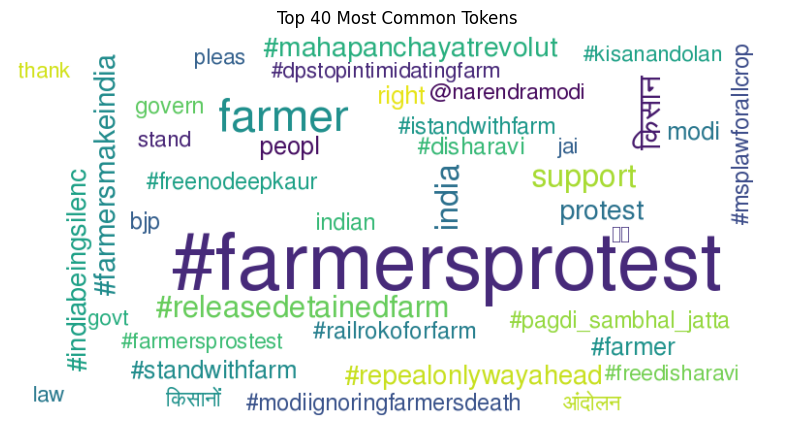

In [276]:
font = "gargi.ttf"

wordcloud = WordCloud(
    width=800,         # width of the word cloud
    height=400,        # height of the word cloud
    background_color='white',  # background color
    colormap='viridis',         # color scheme for the words
    font_path= font,
    max_words=100)
wordcloud.generate_from_frequencies(dict(list(sorted_tokens.items())[:40]))

plt.figure(figsize=(10,6))
plt.title(f"Top 40 Most Common Tokens")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

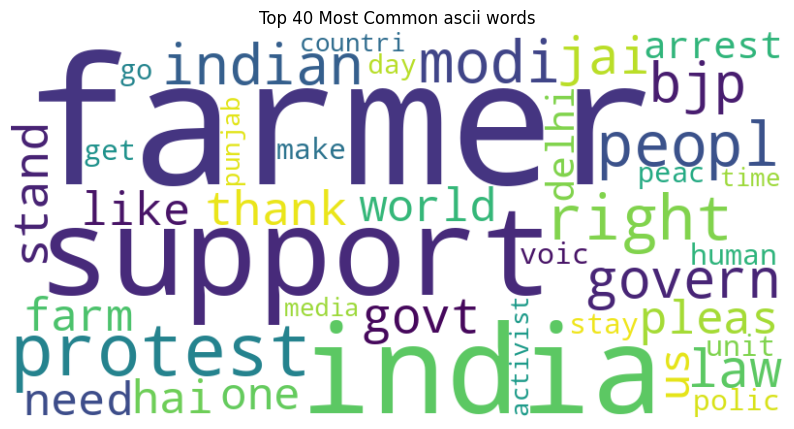

In [277]:
wordcloud = WordCloud(
    width=800,         # width of the word cloud
    height=400,        # height of the word cloud
    background_color='white',  # background color
    colormap='viridis',         # color scheme for the words
    max_words=100)
wordcloud.generate_from_frequencies(dict(list(filtered_tokens.items())[:40]))

plt.figure(figsize=(10,6))
plt.title(f"Top 40 Most Common ascii words")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.axis('off')

In [278]:
retweetsList = []
likesList = []

for tweet in processed_tweets1:
    retweetsList.append(tweet['retweets'])
    likesList.append(tweet['likes'])

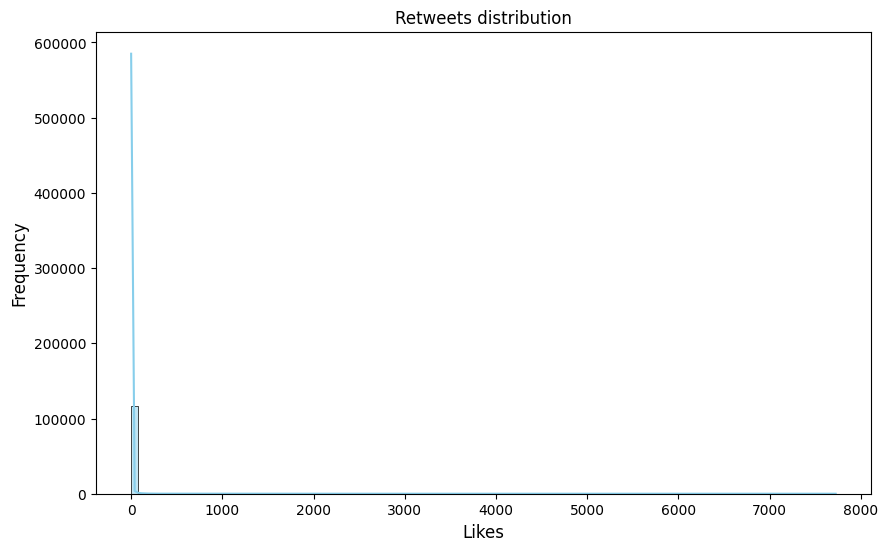

In [279]:
plt.figure(figsize=(10,6))
sns.histplot(retweetsList, bins=100, kde=True, color="skyblue")
plt.title(f"Retweets distribution")
plt.xlabel("Likes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

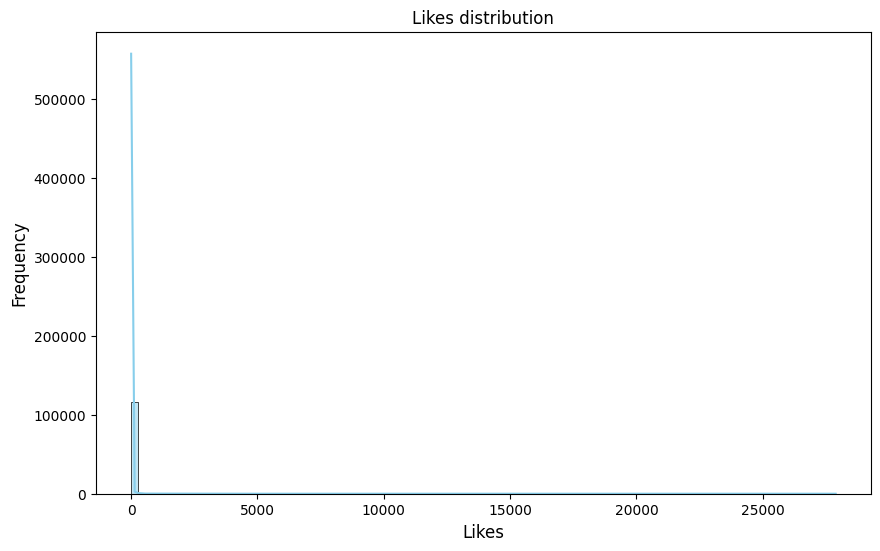

In [280]:
plt.figure(figsize=(10,6))
sns.histplot(likesList, bins=100, kde=True, color="skyblue")
plt.title(f"Likes distribution")
plt.xlabel("Likes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [281]:
sorted_tweets_by_likes = sorted(processed_tweets1, key=lambda item:item['likes'], reverse=True)
print('The most liked tweets are the following:')
for i in range(5):
    print('-------> Top', i + 1, 'tweet with ', sorted_tweets_by_likes[i]['likes'],' likes:')
    print(sorted_tweets_by_likes[i]['tweet'])
    print('-------> from user: ', sorted_tweets_by_likes[i]['userName'],'\n')

The most liked tweets are the following:
-------> Top 1 tweet with  27888  likes:
There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8
-------> from user:  dhruv_rathee 

-------> Top 2 tweet with  25824  likes:
मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान खरीदकर भाग गया। किसान पैसे के लिए धरना दे रहे है।
अब भी बताना पड़ेगा काला क्या है
#FarmLaws #FarmersProtest #किसान_एकता_जिंदाबाद
-------> from user:  RakeshTikaitBKU 

-------> Top 3 tweet with  19284  likes:
लहरों को ख़ामोश देख कर ये ना समझना कि समंदर में रवानी नहीं , हम जब भी उठेंगे तूफ़ान बन कर उठेंगे , बस उठने की अभी ठानी नहीं ... #FarmersProtest                                        #JittegaKisaan
-------> from user:  sherryontopp 

-------> Top 4 tweet with  19198  likes:
हाँ मैं जान

In [282]:
likesList.sort(reverse=False)
likesList= np.array(likesList)

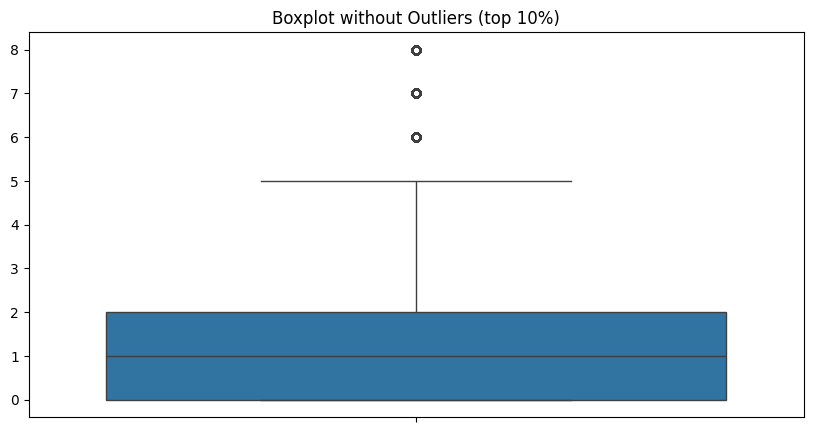

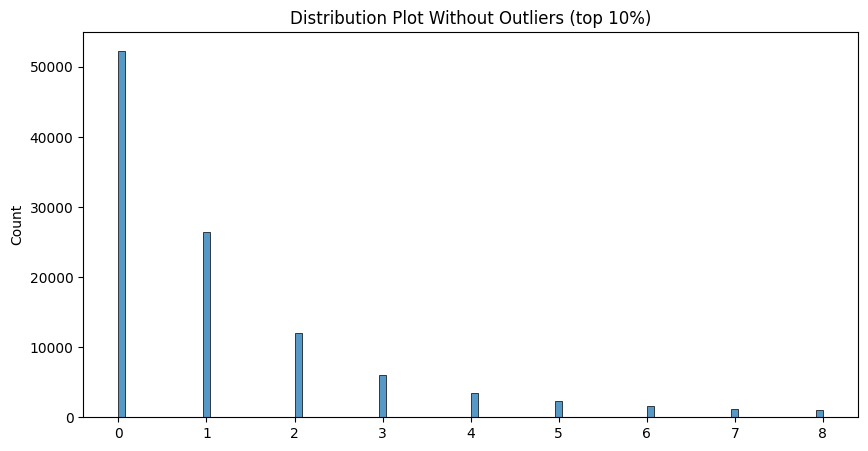

Cleaned Data (Without Outliers): [0 0 0 ... 8 8 8]


In [283]:
upper_bound = np.percentile(likesList, 90)
cleaned_data = likesList[(likesList <= upper_bound)]
plt.figure(figsize=(10, 5))
sns.boxplot(data=cleaned_data)
plt.title("Boxplot without Outliers (top 10%)")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(cleaned_data, bins=100)
plt.title("Distribution Plot Without Outliers (top 10%)")
plt.show()

# Optional: Print cleaned data for confirmation
print("Cleaned Data (Without Outliers):", cleaned_data)

In [284]:
no0likes = likesList[likesList > 100]

In [285]:
print('Out of the ', len(likesList), ' ther are ', len(no0likes), ' tweets with more than 100 likes')

Out of the  117407  ther are  2119  tweets with more than 100 likes


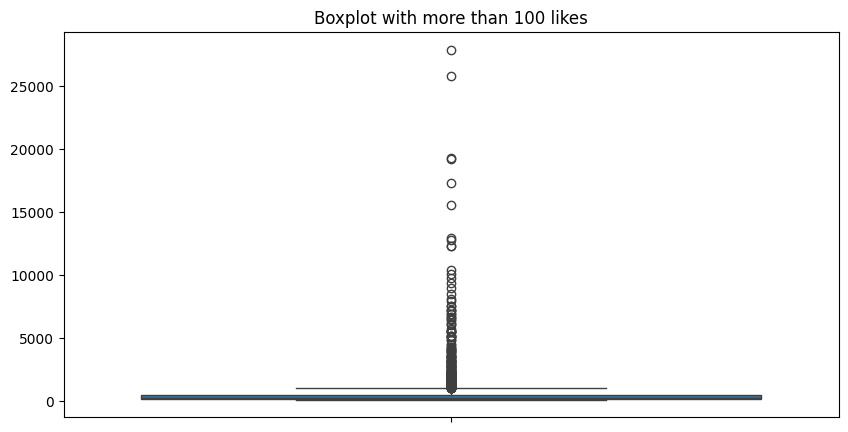

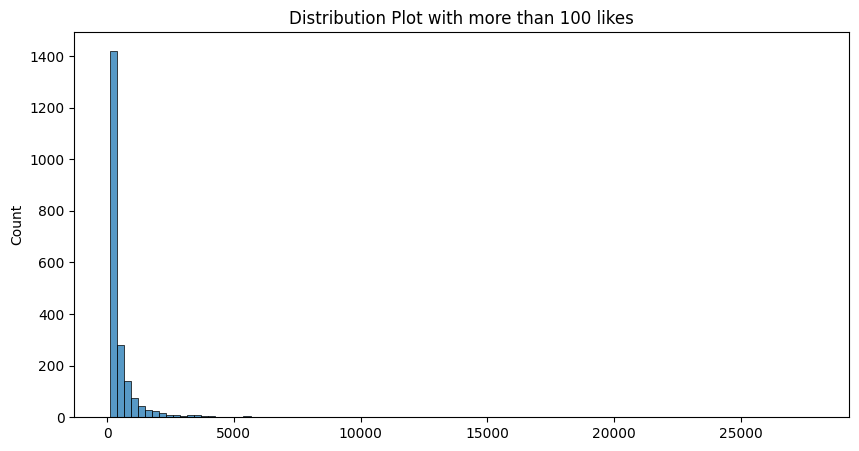

Cleaned Data (Without 0s): [  101   101   101 ... 19284 25824 27888]


In [286]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=no0likes)
plt.title("Boxplot with more than 100 likes")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(no0likes, bins=100)
plt.title("Distribution Plot with more than 100 likes")
plt.show()

# Optional: Print cleaned data for confirmation
print("Cleaned Data (Without 0s):", no0likes)

We will now do the same but for the number of retweets:

In [287]:
sorted_tweets_by_retweets = sorted(processed_tweets1, key=lambda item:item['retweets'], reverse=True)
print('The most liked tweets are the following:')
for i in range(5):
    print('-------> Top', i + 1, 'tweet with ', sorted_tweets_by_retweets[i]['retweets'],' retweets:')
    print(sorted_tweets_by_retweets[i]['tweet'])
    print('-------> from user: ', sorted_tweets_by_retweets[i]['userName'],'\n')

The most liked tweets are the following:
-------> Top 1 tweet with  7723  retweets:
मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान खरीदकर भाग गया। किसान पैसे के लिए धरना दे रहे है।
अब भी बताना पड़ेगा काला क्या है
#FarmLaws #FarmersProtest #किसान_एकता_जिंदाबाद
-------> from user:  RakeshTikaitBKU 

-------> Top 2 tweet with  6164  retweets:
There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8
-------> from user:  dhruv_rathee 

-------> Top 3 tweet with  4673  retweets:
disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. 

disha’s arrest is alarming and the world needs to pay attention. #freedisharavi

https://t.co/IYGsLpNjwZ
-------> from u

In [288]:
for i in range(10):
    print('-> Top', i + 1, 'tweet with most retweet, id:', sorted_tweets_by_retweets[i]['docNum'])
    print('-> Top', i + 1, 'tweet with most likes, id:  ', sorted_tweets_by_likes[i]['docNum'])
    print('\n')


-> Top 1 tweet with most retweet, id: doc_113632
-> Top 1 tweet with most likes, id:   doc_3203


-> Top 2 tweet with most retweet, id: doc_3203
-> Top 2 tweet with most likes, id:   doc_113632


-> Top 3 tweet with most retweet, id: doc_38410
-> Top 3 tweet with most likes, id:   doc_83874


-> Top 4 tweet with most retweet, id: doc_38012
-> Top 4 tweet with most likes, id:   doc_65353


-> Top 5 tweet with most retweet, id: doc_46206
-> Top 5 tweet with most likes, id:   doc_46206


-> Top 6 tweet with most retweet, id: doc_27071
-> Top 6 tweet with most likes, id:   doc_62412


-> Top 7 tweet with most retweet, id: doc_45142
-> Top 7 tweet with most likes, id:   doc_45142


-> Top 8 tweet with most retweet, id: doc_83874
-> Top 8 tweet with most likes, id:   doc_96125


-> Top 9 tweet with most retweet, id: doc_65353
-> Top 9 tweet with most likes, id:   doc_88771


-> Top 10 tweet with most retweet, id: doc_62412
-> Top 10 tweet with most likes, id:   doc_38262




In [289]:
retweetsList.sort(reverse=False)
retweetsList= np.array(retweetsList)

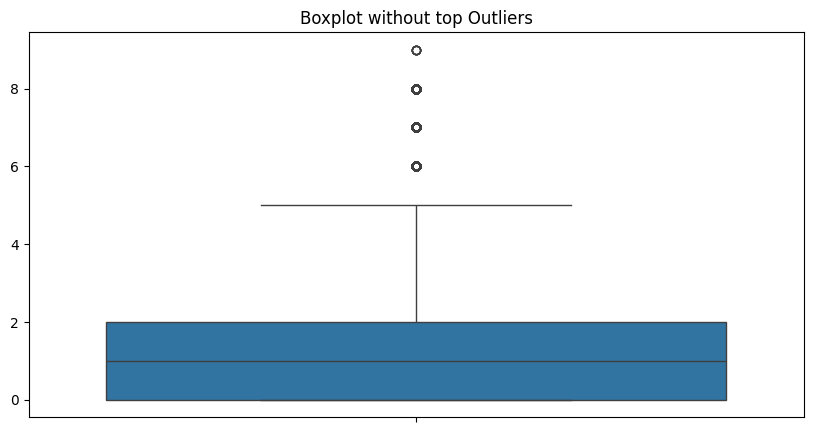

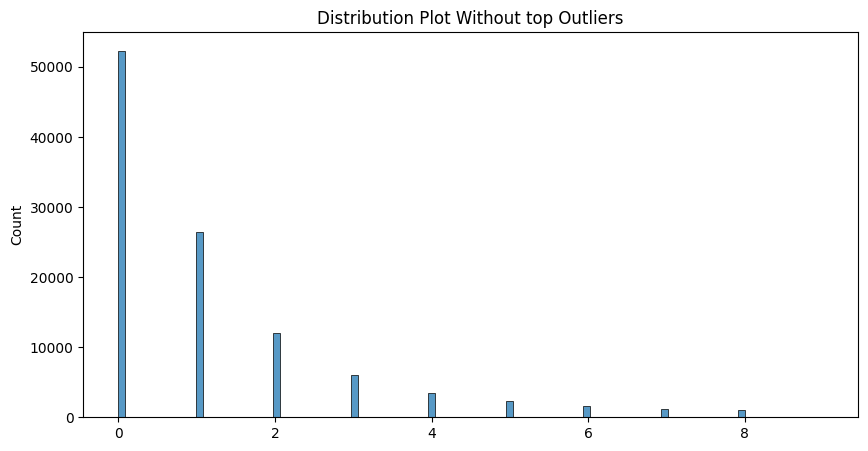

Cleaned Data (Without top Outliers): [0 0 0 ... 9 9 9]


In [290]:
upper_bound = np.percentile(retweetsList, 90)
cleaned_data = likesList[(retweetsList <= upper_bound)]
plt.figure(figsize=(10, 5))
sns.boxplot(data=cleaned_data)
plt.title("Boxplot without top Outliers")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(cleaned_data, bins=100)
plt.title("Distribution Plot Without top Outliers")
plt.show()

print("Cleaned Data (Without top Outliers):", cleaned_data)

In [291]:
no0retweets = retweetsList[retweetsList > 100]

In [292]:
no0retweets

array([ 101,  101,  101, ..., 4673, 6164, 7723])

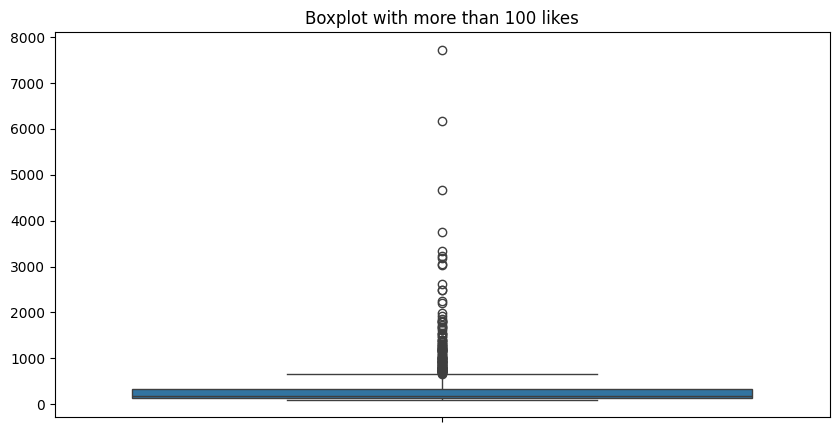

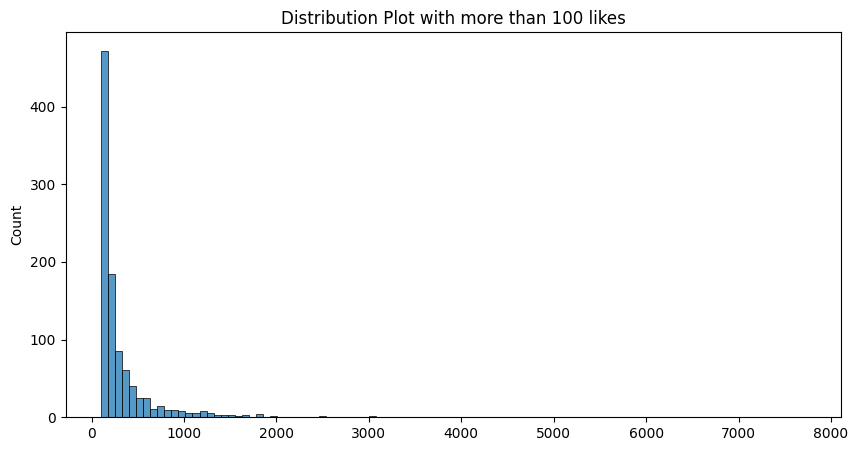

Cleaned Data (with more than 100 likes): [ 101  101  101 ... 4673 6164 7723]


In [293]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=no0retweets)
plt.title("Boxplot with more than 100 likes")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(no0retweets, bins=100)
plt.title("Distribution Plot with more than 100 likes")
plt.show()

print("Cleaned Data (with more than 100 likes):", no0retweets)

# PART 2

## **Inverted Index**

In [294]:
def build_inverted_index(processed_tweets):
    inverted_index = defaultdict(list)

    for doc_num, tweet_data in processed_tweets.items():
        tokens = tweet_data['tokenizedContent']

        for token in tokens:
            if doc_num not in inverted_index[token]:
                inverted_index[token].append(doc_num)

    return inverted_index

In [295]:
inverted_index = build_inverted_index(processed_tweets2)
print(len(inverted_index['farmer']))

12748


## **TF-IDF**

In [296]:
from os import remove
stop_words_english_q = set(stopwords.words('english'))
def build_terms_query(query, lang='en'):
  line = query

  stemmer = PorterStemmer()

  # Transform to lowercase
  line = line.lower()
  line = remove_emojis(line) #additionally we decided to also remove emojis from the text, since they are not relevant for the search
  line = re.sub(r"'", '', line)


  line = re.sub(r'https://[^\s]+', '', line)

  # Tokenize based on the language
  if lang in ['pa', 'hi']:  # Hindi and Punjabi
      tokens = indic_tokenize.trivial_tokenize(line)  # Tokenize for Punjabi
      tokens = combine_hashtags(tokens)
      tokens = combine_at(tokens)
  else:  # English and Indonesian
      tokens = line.split()

  tokens = remove_punctuation_mixed(tokens)


  # Remove stopwords based on language
  if lang == 'en':
      tokens = [x for x in tokens if x not in stop_words_english]
  elif lang == 'id':
      tokens = [x for x in tokens if x not in stop_words_indonesian]
  elif lang == 'hi':
      tokens = [x for x in tokens if x not in stop_words_hindi]
  elif lang == 'pa':
      # Join tokens into a single string for stopword removal
      text_string = ' '.join(tokens)
      filtered_text = remove_stopwords(text_string)  # Remove stopwords
      tokens = filtered_text.split()

  tokens = [x for x in tokens if x not in [',','-','.','|','!','?','!!',':','...','=','/', ';', '(', ')', "'", "।", '\n', '', '_', '"','&amp', '\n\n']] #extra layer of purification upon inspecting the most frequent tokens
  # Perform stemming
  tokens = [stemmer.stem(x) for x in tokens]

  return tokens


In [297]:
def inverted_index_tfidf(query_terms, inverted_index, total_tweets, processed_tweets2, gettfidfs=False):
  tweets_scores = defaultdict(float) #dictionary to store doc_id -> score
  doc_candidates = set(inverted_index[query_terms[0]])
  for item in query_terms[1:]:
    doc_candidates &= set(inverted_index[item])

  for term in query_terms: #for each word
    if term in inverted_index:
      df = len(inverted_index[term]) # we compute document frequency (DF) that is the number of documents containing the term
      idf = np.round(np.log(total_tweets/df), 4) #we compute IDF with the formula
      for doc_id in doc_candidates: #for each document that conatins the term
        term_frequency = processed_tweets2[doc_id]['tokenizedContent'].count(term)   #term frequency of the term in the document
        tf = np.round(term_frequency / len(processed_tweets2[doc_id]), 4) #we compute the tf term_frequency/words in that document
        # we compute tf-idf and add it to the tweet score
        tweets_scores[doc_id] += tf * idf

  #we order the tweet scores in descending order by score
  ranked_tweets = dict(sorted(tweets_scores.items(), key=lambda x: x[1], reverse=True))

  return ranked_tweets

In [298]:
query = "people's rights"
query_terms = build_terms_query(query)
retrieved_docs = inverted_index_tfidf(query_terms, inverted_index, len(processed_tweets2), processed_tweets2) #documents were the query appears ranked by scores

top_10_results = list(retrieved_docs.items())[:10] #we take top 10
for tweet_id, score in top_10_results:
    print(tweet_id, score)



doc_8894 1.37875
doc_27922 1.10573
doc_14469 1.1018299999999999
doc_10386 0.82881
doc_19350 0.82881
doc_18971 0.82881
doc_19327 0.82881
doc_9850 0.82881
doc_41831 0.82881
doc_20570 0.82881


## Evaluation

### Ground Truth

In [299]:
import pandas as pd

gt_df = pd.read_csv('evaluation_gt.csv', delimiter=";")
queries = {1: "people's right", 2: "Indian government"}
score_dfs = []  # List to store df for each query

# Process each query to calculate TF-IDF scores
for query_id, query_text in queries.items():
    # Tokenize the query and calculate TF-IDF scores
    query_terms = build_terms_query(query_text)
    tfidf_scores = inverted_index_tfidf(query_terms, inverted_index, len(processed_tweets2), processed_tweets2)

    # Convert tfidf_scores to a DataFrame and add the query_id
    query_df = pd.DataFrame(tfidf_scores.items(), columns=["docId", "score"])
    query_df["query_id"] = query_id
    score_dfs.append(query_df)

# Concatenate all query-specific DataFrames into one
all_scores_df = pd.concat(score_dfs, ignore_index=True)

# Merge the TF-IDF scores with the ground truth DataFrame
mydf = gt_df.merge(all_scores_df, on=["docId", "query_id"], how="left")

# Fill missing scores with 0
mydf["score"].fillna(0, inplace=True)

mydf.head(100)


<ipython-input-299-4acc94ae32c3>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mydf["score"].fillna(0, inplace=True)


docId  query_id  label    score
0     doc_156         1      0  0.00000
1    doc_1039         1      0  0.00000
2    doc_1047         1      1  0.55189
3    doc_1685         1      0  0.00000
4    doc_2100         1      1  0.82686
5    doc_2732         1      0  0.55189
6    doc_3287         1      1  0.55189
7    doc_3474         1      1  0.00000
8    doc_3497         1      0  0.00000
9    doc_3570         1      1  0.55189
10   doc_3954         1      0  0.00000
11   doc_4053         1      1  0.82881
12   doc_5480         1      1  0.55189
13   doc_5512         1      1  0.55189
14   doc_5751         1      1  0.55189
15   doc_5899         1      0  0.00000
16   doc_6477         1      1  0.82881
17   doc_8066         1      1  0.55189
18   doc_8819         1      0  0.55189
19   doc_9180         1      0  0.00000
20   doc_9696         1      1  0.82881
21   doc_9850         1      1  0.82881
22   doc_9937         1      1  0.55189
23  doc_10048         1      1  0.55189
24  doc_10272         1      0  0.00000
25  doc_11229         1      0  0.00000
26  doc_11298         1      0  0.00000
27  doc_12080         1      0  0.00000
28  doc_16436         1      0  0.00000
29  doc_23088         1      0  0.00000
30    doc_103         2      1  0.58553
31   doc_1566         2      1  0.87388
32   doc_1651         2      1  0.58553
33   doc_1666         2      1  0.58553
34   doc_1785         2      1  0.58553
35   doc_2528         2      1  0.58553
36   doc_2653         2      1  0.58553
37   doc_3005         2      1  0.58553
38   doc_3076         2      1  0.58553
39   doc_3116         2      1  0.58553
40   doc_3646         2      1  0.00000
41   doc_3682         2      1  0.58553
42   doc_3927         2      1  0.87388
43   doc_4176         2      1  0.58553
44   doc_4304         2      1  0.58553
45  doc_43341         2      0  0.00000
46  doc_43540         2      0  0.00000
47     doc_12         2      0  0.00000
48     doc_17         2      0  0.00000
49     doc_18         2      0  0.00000
50     doc_19         2      0  0.00000
51    doc_108         2      0  0.00000
52    doc_120         2      0  0.00000
53    doc_162         2      0  0.00000
54    doc_189         2      0  0.00000
55    doc_285         2      0  0.00000
56    doc_319         2      0  0.00000
57    doc_427         2      0  0.00000
58    doc_460         2      0  0.00000
59    doc_748         2      0  0.00000

### P@K

In [300]:
def precision_at_k(doc_score, y_score, k):
    order = np.argsort(y_score)[::-1]
    #doc_score = np.take(doc_score, order[:k])
    doc_score = doc_score[order[:k]]
    relevant = sum(doc_score == 1)
    return float(relevant) / k

### R@K

In [301]:
def recall_at_k(doc_score, y_score, k=10):
    doc_score = np.asarray(doc_score)
    y_score = np.asarray(y_score)
    order = np.argsort(-y_score)
    top_k = doc_score[order[:k]]

    relevant = np.sum(top_k == 1)
    total_relevant = np.sum(doc_score == 1)

    if total_relevant == 0:
        return 0.0

    return relevant / total_relevant

### AP@K

In [302]:
def avg_precision_at_k(doc_score, y_score, k):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    prec_at_i = 0
    prec_at_i_list = []
    number_of_relevant = 0
    number_to_iterate = min(k, len(order))
    for i in range(number_to_iterate):
        if doc_score[order[i]] == 1:
            number_of_relevant += 1
            prec_at_i = number_of_relevant / (i + 1)
            prec_at_i_list.append(prec_at_i)
    if number_of_relevant == 0:
        return 0
    else:
      return np.sum(prec_at_i_list) / number_of_relevant

### F1-score@K

In [303]:
def f1_at_k(doc_score, y_score, k=10):
    precision = precision_at_k(doc_score, y_score, k)
    recall = recall_at_k(doc_score, y_score, k)
    if precision + recall == 0: #avoid division by 0
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

### MAP

In [304]:
def map_at_k(search_res, k=10):
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["label"]),
                   np.array(curr_data["score"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

### MRR

In [305]:
def rr_at_k(doc_score, y_score, k=10):

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"


In [306]:
def mrr_at_k(search_results, k=10):
    """
    Computes Mean Reciprocal Rank (MRR) at k over multiple queries.

    Parameters
    ----------
    search_results: DataFrame containing columns 'query_id', 'is_relevant', and 'predicted_relevance'.
    k : int, optional (default=10)
        Number of top-ranked documents to consider for each query.

    Returns
    -------
    mrr : float
        Mean Reciprocal Rank (MRR) at k over all queries.
    """
    RRs = []

    # Loop over each unique query
    for q in search_results['query_id'].unique():
        # Get labels and scores for the current query
        labels = np.array(search_results[search_results['query_id'] == q]["label"])
        scores = np.array(search_results[search_results['query_id'] == q]["score"])

        # Calculate RR for the current query and append to RRs list
        RRs.append(rr_at_k(labels, scores, k))

    # Calculate MRR as the mean of all Reciprocal Ranks
    return np.round(float(sum(RRs) / len(RRs)), 4) if RRs else 0.0

### NDCG

In [307]:
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

## Evaluation of queries: ["people's rights", "Indian Government"]

In [308]:
# Define the queries and assign unique labels automatically
queries = ["people's rights", "Indian Government"]
query_labels = [1, 2]

# Loop over each query with its assigned query_id
for query, query_id in zip(queries, query_labels):
    print(f"Results for query: {query}")

    # Filter `mydf` for this query using `query_id`
    query_df = mydf[mydf["query_id"] == query_id]

    # Compute precision, recall, F1, average precision, and NDCG for the current query
    k = 10  # Adjust `k` as required
    precision = precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    recall = recall_at_k(query_df['label'].values, query_df['score'].values, k=k)
    f1 = f1_at_k(query_df['label'].values, query_df['score'].values, k=k)
    avg_precision = avg_precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    ndcg = ndcg_at_k(query_df['label'].values, query_df['score'].values, k=k)

    # Calculate MAP and MRR for the current query if needed
    map_query = map_at_k(query_df, k=k)  # Alternatively, calculate across all queries outside the loop
    mrr_query = mrr_at_k(query_df, k=k)  # Same as above

    # Display individual metrics for the current query
    print(f"precision@{k} for '{query}': {precision}")
    print(f"recall@{k} for '{query}': {recall}")
    print(f"f1@{k} for '{query}': {f1}")
    print(f"avg_precision@{k} for '{query}': {avg_precision}")
    print(f"ndcg@{k} for '{query}': {ndcg}")
    print(f"map@{k} for '{query}': {map_query}")
    print(f"mrr@{k} for '{query}': {mrr_query}")
    print()

# Alternatively, calculate overall MAP and MRR across both queries
overall_map = map_at_k(mydf, k=k)
overall_mrr = mrr_at_k(mydf, k=k)

print(f"Overall map@{k}: {overall_map}")
print(f"Overall mrr@{k}: {overall_mrr}")


Results for query: people's rights
precision@10 for 'people's rights': 0.9
recall@10 for 'people's rights': 0.6666666666666666
f1@10 for 'people's rights': 0.7659574468085106
avg_precision@10 for 'people's rights': 0.9626543209876544
ndcg@10 for 'people's rights': 0.9266
map@10 for 'people's rights': (0.9626543209876544, [0.9626543209876544])
mrr@10 for 'people's rights': 1.0

Results for query: Indian Government
precision@10 for 'Indian Government': 1.0
recall@10 for 'Indian Government': 0.6666666666666666
f1@10 for 'Indian Government': 0.8
avg_precision@10 for 'Indian Government': 1.0
ndcg@10 for 'Indian Government': 1.0
map@10 for 'Indian Government': (1.0, [1.0])
mrr@10 for 'Indian Government': 1.0

Overall map@10: (0.9813271604938272, [0.9626543209876544, 1.0])
Overall mrr@10: 1.0


## Our 5 Queries

### Select queries

In [309]:
my_queries = ["bjp govern","march to delhi","jai kisaan","punjab to delhi", "farmer's support"]

In [310]:
for i, query in enumerate(my_queries, start=1):
    print(f"\nResults for Query {i}: '{query}'")
    query_terms = build_terms_query(query)
    retrieved_docs = inverted_index_tfidf(query_terms, inverted_index, len(processed_tweets2), processed_tweets2)

    top_10_results = list(retrieved_docs.items())[:10]

    print("Top 10 documents and scores:")
    for tweet_id, score in top_10_results:
        print(f"Document ID: {tweet_id}, Score: {score}")



Results for Query 1: 'bjp govern'
Top 10 documents and scores:
Document ID: doc_14219, Score: 2.21851
Document ID: doc_31836, Score: 1.24402
Document ID: doc_29486, Score: 1.24402
Document ID: doc_5957, Score: 0.94684
Document ID: doc_22469, Score: 0.94684
Document ID: doc_9441, Score: 0.94684
Document ID: doc_44921, Score: 0.94684
Document ID: doc_5956, Score: 0.94684
Document ID: doc_10526, Score: 0.94684
Document ID: doc_10766, Score: 0.94684

Results for Query 2: 'march to delhi'
Top 10 documents and scores:
Document ID: doc_8853, Score: 1.84088
Document ID: doc_3218, Score: 1.6098400000000002
Document ID: doc_3224, Score: 1.6098400000000002
Document ID: doc_3227, Score: 1.6098400000000002
Document ID: doc_43032, Score: 0.92044
Document ID: doc_30902, Score: 0.92044
Document ID: doc_44534, Score: 0.92044
Document ID: doc_7886, Score: 0.92044
Document ID: doc_218, Score: 0.92044
Document ID: doc_2874, Score: 0.92044

Results for Query 3: 'jai kisaan'
Top 10 documents and scores:
Do

### Find relevants manually

In [311]:
#to look if doc relevant or not to create the csv manually (binary)
for query in my_queries:
  print('The query:', query)
  query_terms = build_terms_query(query)
  print(query_terms)
  retrieved_docs = inverted_index_tfidf(query_terms, inverted_index, len(processed_tweets2), processed_tweets2)
  top10 = list(retrieved_docs.items())[:10]
  for doc_id, score in top10:
    print(doc_id, score)
    print(processed_tweets2[doc_id]['tokenizedContent'])
  print( )

The query: bjp govern
['bjp', 'govern']
doc_14219 2.21851
['bjp', 'step', '1', 'polic', 'intimid', 'bjp', 'step', '2', 'arrest', 'young', 'women', 'bjp', 'step', '3', 'delay', 'releas', 'bjp', 'isnt', 'govern', 'bjp', 'ambani', 'govern', '#dpstopintimidatingfarm', '#farmersprotest']
doc_31836 1.24402
['ravi', 'ji', 'bjp', 'govern', 'take', 'action', 'ideolog', 'person', 'shame', 'bjp', 'govern', '@twitter', 'pl', 'take', 'appropri', 'action', 'spread', 'hate', 'threat', 'societi', '#farmersprotest', '#freedisharavi']
doc_29486 1.24402
['bjp', 'govern', 'one', 'corrupt', 'govern', 'none', 'minist', 'educ', 'crimin', 'hide', 'crime', 'becom', 'minist', 'one', 'approach', 'goon', 'shame', 'modi', 'bjp', '##resignmodi', '##farmersprotest']
doc_5957 0.94684
['@rakeshtikaitbku', '@ndtvindia', '@kisanektamorcha', '@saurabhbku', '@dr_anilchaudhri', '@radhika1503', '@dmalikbku', '@digamberbku', '@ahindinew', '@sushant_say', '@pti_new', 'delhi-gurgaon', 'road', 'delhi-noida', 'road', 'two', 'maj

### Evaluation of our 5 queries

In [312]:
gt_df = pd.read_csv('/content/our_evaluation.csv', delimiter=";")

# Define the queries and assign unique labels
my_queries = {1: "bjp govern", 2: "march to delhi", 3: "jai kisaan", 4: "punjab to delhi", 5: "farmer's support"}

# List to store DataFrames for each query's TF-IDF scores
score_dfs = []

# Process each query to calculate TF-IDF scores
for query_id, query_text in my_queries.items():
    # Preprocess query terms and calculate TF-IDF scores
    query_terms = build_terms_query(query_text)
    tfidf_scores = inverted_index_tfidf(query_terms, inverted_index, len(processed_tweets2), processed_tweets2)

    # Convert TF-IDF scores to a DataFrame and add the query_id column
    query_df = pd.DataFrame(tfidf_scores.items(), columns=["docId", "score"])
    query_df["query_id"] = query_id
    score_dfs.append(query_df)

# Concatenate all query-specific DataFrames into one DataFrame
all_scores_df = pd.concat(score_dfs, ignore_index=True)

# Merge the TF-IDF scores with the ground truth DataFrame on `docId` and `query_id`
mydf2 = gt_df.merge(all_scores_df, on=["docId", "query_id"], how="left")

# Fill missing scores with 0
mydf2["score"].fillna(0, inplace=True)

# Display the resulting DataFrame
mydf2.head(46)


<ipython-input-312-df63f656d5be>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mydf2["score"].fillna(0, inplace=True)


docId  query_id  label    score
0   doc_14219         1      1  2.21851
1    doc_9441         1      1  0.94684
2   doc_23083         1      0  0.91919
3    doc_1441         1      1  0.62201
4   doc_38114         1      0  0.91919
5   doc_32642         1      1  0.62201
6   doc_44921         1      1  0.94684
7    doc_5957         1      1  0.94684
8   doc_10526         1      1  0.94684
9   doc_42875         1      0  0.91919
10   doc_8853         2      0  1.84088
11  doc_44534         2      1  0.92044
12   doc_6245         2      0  0.92044
13   doc_3200         2      1  0.92044
14  doc_20612         2      1  0.92044
15   doc_3224         2      0  1.60984
16    doc_218         2      1  0.92044
17  doc_20612         2      1  0.92044
18    doc_154         2      1  0.92044
19   doc_7886         2      0  0.92044
20  doc_24885         3      1  2.17819
21   doc_7705         3      1  1.31447
22  doc_17699         3      1  1.31447
23    doc_779         3      1  1.31447
24  doc_35481         3      0  1.76522
25  doc_16176         3      1  1.31447
26  doc_19329         3      0  1.31447
27    doc_348         3      1  1.31447
28   doc_7725         3      1  1.31447
29   doc_7652         3      0  1.31447
30    0.73752         4      0  0.00000
31  doc_25989         4      1  0.73752
32  doc_46425         4      0  0.73752
33  doc_41733         4      1  0.73752
34  doc_38845         4      0  1.08222
35  doc_17395         4      1  1.13034
36  doc_21757         4      0  1.42692
37   doc_9703         4      1  1.08222
38  doc_44244         4      1  1.08222
39  doc_46237         4      0  0.73752
40  doc_22998         5      1  1.05417
41   doc_4340         5      1  0.92070
42   doc_7040         5      1  0.92070
43  doc_30753         5      0  0.83625
44  doc_10456         5      1  0.78723
45  doc_10404         5      0  0.78723

In [313]:
# Define the queries and assign labels automatically
my_queries_list = ["bjp govern", "march to delhi", "jai kisaan", "punjab to delhi", "farmer's support"]

# Loop over each query with its assigned query_id
for i, query in enumerate(my_queries_list, start=1):  # start=1 to match the query_id 1, 2, 3, ...
    print(f"Results for query: {query}")

    # Filter `mydf2` for the current query based on `query_id`
    query_df = mydf2[mydf2["query_id"] == i]

    # Compute precision, recall, f1, average precision, ndcg, and other metrics at k for the current query
    k = 10  # Adjust `k` as needed
    precision = precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    recall = recall_at_k(query_df['label'].values, query_df['score'].values, k=k)
    f1 = f1_at_k(query_df['label'].values, query_df['score'].values, k=k)
    avg_precision = avg_precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    ndcg = ndcg_at_k(query_df['label'].values, query_df['score'].values, k=k)

    # Display individual metrics for the current query
    print(f"precision@{k} for '{query}': {precision}")
    print(f"recall@{k} for '{query}': {recall}")
    print(f"f1@{k} for '{query}': {f1}")
    print(f"avg_precision@{k} for '{query}': {avg_precision}")
    print(f"ndcg@{k} for '{query}': {ndcg}")
    print()

# Calculate MAP and MRR over all queries
map_score = map_at_k(mydf2, k=k)
mrr_score = mrr_at_k(mydf2, k=k)

# Display MAP and MRR
print(f"map@{k}: {map_score}")
print(f"mrr@{k}: {mrr_score}")


Results for query: bjp govern
precision@10 for 'bjp govern': 0.7
recall@10 for 'bjp govern': 1.0
f1@10 for 'bjp govern': 0.8235294117647058
avg_precision@10 for 'bjp govern': 0.9095238095238096
ndcg@10 for 'bjp govern': 0.9727

Results for query: march to delhi
precision@10 for 'march to delhi': 0.6
recall@10 for 'march to delhi': 1.0
f1@10 for 'march to delhi': 0.7499999999999999
avg_precision@10 for 'march to delhi': 0.4910714285714286
ndcg@10 for 'march to delhi': 0.639

Results for query: jai kisaan
precision@10 for 'jai kisaan': 0.7
recall@10 for 'jai kisaan': 1.0
f1@10 for 'jai kisaan': 0.8235294117647058
avg_precision@10 for 'jai kisaan': 0.666156462585034
ndcg@10 for 'jai kisaan': 0.8401

Results for query: punjab to delhi
precision@10 for 'punjab to delhi': 0.5
recall@10 for 'punjab to delhi': 1.0
f1@10 for 'punjab to delhi': 0.6666666666666666
avg_precision@10 for 'punjab to delhi': 0.6087301587301587
ndcg@10 for 'punjab to delhi': 0.7448

Results for query: farmer's support


## Scatter Plot

In [314]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def tweets_word2vec_tsne(tweets, model):
    # Step 1: Calculate tweet vectors by averaging word vectors
    tweet_vectors = []
    for tweet in tweets:
        # Only include words in the Word2Vec vocabulary
        word_vectors = [model.wv[word] for word in tweet if word in model.wv]
        if word_vectors:
            tweet_vector = np.mean(word_vectors, axis=0)  # Average the word vectors
            tweet_vectors.append(tweet_vector)
        else:
            tweet_vectors.append(np.zeros(model.vector_size))  # Add a zero vector if no words are in the model

    tweet_vectors = np.array(tweet_vectors)

    return tweet_vectors

def reduce_tweet_vectors(tweet_vectors, dims=2, use_tsne=True):
    # Step 2: Apply dimensionality reduction (T-SNE or PCA)
    if use_tsne:
        tsne = TSNE(n_components=dims, random_state=42, perplexity=30)
        reduced_vectors = tsne.fit_transform(tweet_vectors)
    else:
        pca = PCA(n_components=dims)
        reduced_vectors = pca.fit_transform(tweet_vectors)
    return reduced_vectors

def plot_reduced_labels(reduced_vectors, labels):
    # Step 3: Plot the reduced vectors in a scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7, s=50, cmap="viridis")
    plt.title("2D Scatter Plot of Tweets (using Word2Vec + {})".format("T-SNE" if use_tsne else "PCA"))
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

In [315]:
tokenizedtweets = [tweet['tokenizedContent'] for tweet in processed_tweets1]
model = Word2Vec(sentences=tokenizedtweets, vector_size=100, window=5, min_count=1, workers=4)

In [316]:
vectors= tweets_word2vec_tsne(tokenizedtweets, model)
print(vectors)

[[-0.8218268   0.16278924  0.33549342 ...  0.5041339  -0.2790088
  -1.4252826 ]
 [-0.68730885  0.00401963 -0.00205742 ...  0.27195463 -0.129472
  -1.1349671 ]
 [-0.24558115 -0.36124122 -0.049357   ... -0.1863022  -0.6757398
   0.22862615]
 ...
 [-0.82119113 -0.07130441  0.552971   ...  0.46332264  0.32676652
  -1.4992    ]
 [-0.33243623  0.6039826  -0.47426757 ... -0.4389019  -0.43307552
   0.56297994]
 [-0.4854741  -0.38085318  0.29780215 ... -0.15649368  0.43549725
  -1.054979  ]]


In [317]:
vectors_reduced = reduce_tweet_vectors(vectors, dims=2,use_tsne=False)
#We are using PCA, since it is more familiar to us and the implementation of the TSNE was not responding

In [318]:
processed_tweets1[0]['docNum']

'doc_0'

In [319]:
labels = np.zeros([len(vectors_reduced)])
docs = mydf2['docId'].tolist()

for i, q in enumerate(['Query 1', 'Query 2', 'Query 3', 'Query 4']):
  for pos, tweet in enumerate(processed_tweets1):
    if tweet['docNum'] in docs:
      for j, qid in enumerate(mydf2[mydf2['docId'] == tweet['docNum']]['query_id'].tolist()):
        if qid == i + 1:
          if mydf2[mydf2['docId'] == tweet['docNum']]['label'].tolist()[j] == 1:
            labels[pos] = i + 1





In [320]:
for i, label in enumerate(labels):
  if label != 0:
    print(i, label)

450 2.0
659 2.0
913 3.0
1854 3.0
3369 1.0
7625 2.0
13865 1.0
17984 3.0
18017 3.0
22183 1.0
22975 4.0
24946 1.0
33453 1.0
37104 3.0
40438 4.0
41258 3.0
48617 2.0
59912 3.0
62291 4.0
77505 1.0
98250 4.0
105614 4.0
106346 2.0
107450 1.0


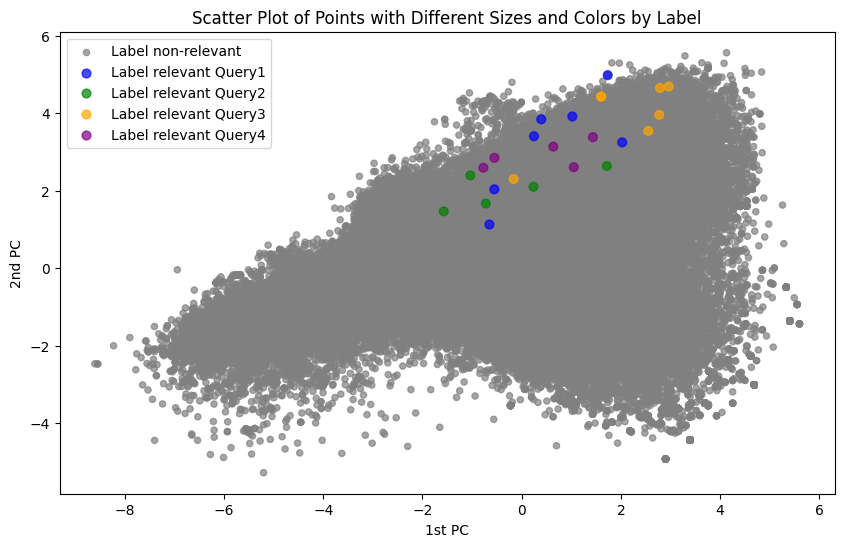

In [321]:
colors = ['gray', 'blue', 'green', 'orange', 'purple']  # Color for each label 0-4
sizes = np.where(labels == 0, 20, 40)  # Size: 20 if label is 0, otherwise 40
lablesnames = ['non-relevant', 'relevant Query1', 'relevant Query2', 'relevant Query3', 'relevant Query4']

# Plot
plt.figure(figsize=(10, 6))
for label in range(5):  # Iterate through each label (0 to 4)
    plt.scatter(
        vectors_reduced[labels == label, 0], vectors_reduced[labels == label, 1],
        c=colors[label], s=sizes[labels == label],
        label=f'Label {lablesnames[label]}', alpha=0.7
    )

plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.title('Scatter Plot of Points with Different Sizes and Colors by Label')
plt.legend()
plt.show()

In [322]:
vectors_reduced3dim = reduce_tweet_vectors(vectors, dims=3,use_tsne=False)


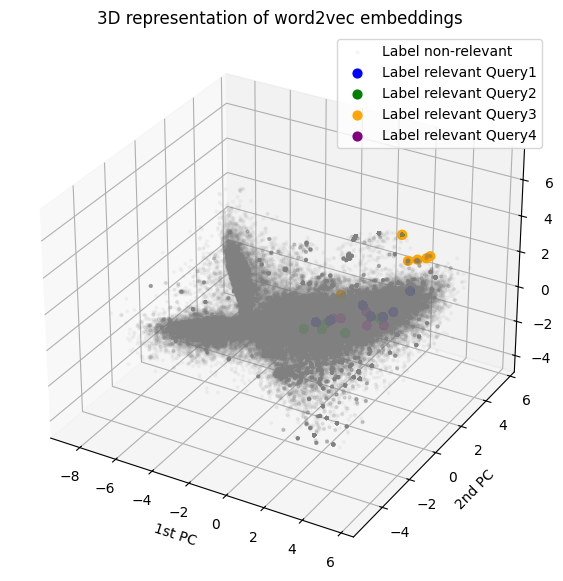

In [323]:
# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sizes = np.where(labels == 0, 4, 40)  # Size: 20 if label is 0, otherwise 40

# Plot each label in a different color and size
for label in range(5):  # Iterate through each label (0 to 4)
    alpha = 0.05 if label == 0 else 1 # Set alpha to 0.3 for label 0 (translucent), otherwise 0.7

    ax.scatter(
        vectors_reduced3dim[labels == label, 0], vectors_reduced3dim[labels == label, 1], vectors_reduced3dim[labels == label, 2],
        c=colors[label], s=sizes[labels == label],
        label=f'Label {lablesnames[label]}', alpha=alpha
    )

# Label axes and add title and legend
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.title('3D representation of word2vec embeddings')
plt.legend()
plt.show()


# PART 3

## TF-IDF + cosine similarity

In [324]:
def inverted_index_tfidf_cos(query_terms, inverted_index, total_tweets, processed_tweets2, gettfidfs=False):
  tweets_scores = defaultdict(float) #dictionary to store doc_id -> score
  doc_candidates = set(inverted_index[query_terms[0]])
  for item in query_terms[1:]:
    doc_candidates &= set(inverted_index[item])

  query_tfidf = defaultdict(float)
  query_term_counts = {term: query_terms.count(term) for term in set(query_terms)}  # Term frequencies in query

  for term, term_frequency in query_term_counts.items():
      if term in inverted_index:
          df = len(inverted_index[term])
          idf = np.log(total_tweets / df)
          tf = term_frequency / len(query_terms)  # Calculate TF for the query
          query_tfidf[term] = tf * idf

  for doc_id in doc_candidates:
      doc_tfidf = defaultdict(float)

      # Calculate TF-IDF for each term in the document
      for term in set(processed_tweets2[doc_id]['tokenizedContent']):
          if term in inverted_index:
              df = len(inverted_index[term])
              idf = np.log(total_tweets / df)
              term_frequency = processed_tweets2[doc_id]['tokenizedContent'].count(term)
              tf = term_frequency / len(processed_tweets2[doc_id]['tokenizedContent'])
              doc_tfidf[term] = tf * idf


      doc_magnitude = np.sqrt(sum(value ** 2 for value in doc_tfidf.values()))
      if doc_magnitude != 0:
            normalized_doc_tfidf = {term: value / doc_magnitude for term, value in doc_tfidf.items()}
      else:
            normalized_doc_tfidf = doc_tfidf
      #cosine similarity
      dot_product = sum(query_tfidf[term] * normalized_doc_tfidf.get(term, 0) for term in query_terms)


      tweets_scores[doc_id] = dot_product

  #we order the tweet scores in descending order by score
  ranked_tweets = dict(sorted(tweets_scores.items(), key=lambda x: x[1], reverse=True))

  return ranked_tweets

In [325]:
query = "bjp govern"
query_terms = build_terms_query(query)
retrieved_docs = inverted_index_tfidf_cos(query_terms, inverted_index, len(processed_tweets2), processed_tweets2) #documents were the query appears ranked by scores

top_20_results_tf_idf = list(retrieved_docs.items())[:20]
for tweet_id, score in top_20_results_tf_idf:
    print(tweet_id, score)

top_20_docs_tf_idf = [doc_id for doc_id, score in top_20_results_tf_idf]

doc_41499 1.6751627947056038
doc_2519 1.6751627947056038
doc_24137 1.4720852733787275
doc_27572 1.425472159805489
doc_30296 1.348454510746833
doc_3830 1.3333302837178622
doc_41603 1.2699537848183624
doc_31881 1.242236235045464
doc_36665 1.2158573473194572
doc_31855 1.2007248840195675
doc_14219 1.1311687195120934
doc_31877 1.0980516627544366
doc_14611 1.0221273687235828
doc_9824 0.9939976339097466
doc_25953 0.924386176787286
doc_25651 0.8756524985557856
doc_47884 0.87542535120063
doc_42875 0.795203019096598
doc_31836 0.7924456998570799
doc_1441 0.7530301690002772


## Our-Score + cosine similarity

In [326]:
from sklearn.preprocessing import MinMaxScaler

def custom_score_cosine(query_terms, inverted_index, total_tweets, processed_tweets, alpha=0.5, beta=0.3, gamma=0.2):
    tweets_scores = defaultdict(float)
    doc_candidates = set(inverted_index[query_terms[0]])
    for item in query_terms[1:]:
        doc_candidates &= set(inverted_index[item])

    query_tfidf = defaultdict(float)
    query_term_counts = {term: query_terms.count(term) for term in set(query_terms)}

    for term, term_frequency in query_term_counts.items():
        if term in inverted_index:
            df = len(inverted_index[term])
            idf = np.log(total_tweets / df)
            tf = term_frequency / len(query_terms)
            query_tfidf[term] = tf * idf

    # Collect likes and retweets for normalization only for the relevant documents
    likes = np.array([processed_tweets[doc_id]['likes'] for doc_id in doc_candidates])
    retweets = np.array([processed_tweets[doc_id]['retweets'] for doc_id in doc_candidates])

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    normalized_likes = scaler.fit_transform(likes.reshape(-1, 1)).flatten()
    normalized_retweets = scaler.fit_transform(retweets.reshape(-1, 1)).flatten()

    # Create mappings of normalized values for each doc_id
    likes_map = dict(zip(doc_candidates, normalized_likes))
    retweets_map = dict(zip(doc_candidates, normalized_retweets))

    for doc_id in doc_candidates:
        doc_tfidf = defaultdict(float)
        for term in set(processed_tweets[doc_id]['tokenizedContent']):
            if term in inverted_index:
                df = len(inverted_index[term])
                idf = np.log(total_tweets / df)
                term_frequency = processed_tweets[doc_id]['tokenizedContent'].count(term)
                tf = term_frequency / len(processed_tweets[doc_id]['tokenizedContent'])
                doc_tfidf[term] = tf * idf

        doc_magnitude = np.sqrt(sum(value ** 2 for value in doc_tfidf.values()))
        if doc_magnitude != 0:
              normalized_doc_tfidf = {term: value / doc_magnitude for term, value in doc_tfidf.items()}

        else:
              normalized_doc_tfidf = doc_tfidf
        #cosine similarity
        dot_product = sum(query_tfidf[term] * normalized_doc_tfidf.get(term, 0) for term in query_terms)

        if  doc_magnitude != 0:
            # Retrieve normalized popularity scores
            normalized_likes = likes_map[doc_id]
            normalized_retweets = retweets_map[doc_id]
            popularity_score = (alpha * dot_product) + (beta * normalized_likes) + (gamma * normalized_retweets)

            tweets_scores[doc_id] = popularity_score

    ranked_tweets = dict(sorted(tweets_scores.items(), key=lambda x: x[1], reverse=True))
    return ranked_tweets


In [327]:
our_score = custom_score_cosine(query_terms, inverted_index, len(processed_tweets2), processed_tweets2, alpha=0.5, beta=0.3, gamma=0.2)

top_20_results_our_score = list(our_score.items())[:20] #we take top 10
for tweet_id, score in top_20_results_our_score:
    print(tweet_id, score)

top_20_docs_our_score = [doc_id for doc_id, score in top_20_results_our_score]

doc_41499 0.8451763340616627
doc_2519 0.8375813973528019
doc_24137 0.7360426366893638
doc_27572 0.7127360799027445
doc_3830 0.6752245149752663
doc_30296 0.6742272553734165
doc_41603 0.6349768924091812
doc_31881 0.621118117522732
doc_36665 0.6079286736597286
doc_31855 0.6003624420097837
doc_46582 0.5903472300782637
doc_14219 0.5717627804914295
doc_31877 0.5490258313772183
doc_18047 0.5416867934893673
doc_14611 0.5329443353563664
doc_9824 0.5107721743991168
doc_1347 0.49393473297731866
doc_25953 0.4721689774834561
doc_47884 0.4400936279812674
doc_25651 0.4378262492778928


## BM25

In [328]:
def doc_ave(processed_tweets2):
  doc_lengths = defaultdict(float)
  total_docs = 0
  ave = 0
  for doc_id in processed_tweets2:
    Ld = len(processed_tweets2[doc_id]['tokenizedContent'])
    doc_lengths[doc_id] = Ld
    ave += Ld
    total_docs = total_docs + 1

  average_length = ave / total_docs if total_docs > 0 else 0  # Avoid division by zero
  return average_length, doc_lengths

In [329]:
Lave, doc_lengths = doc_ave(processed_tweets2)
print(Lave)

print("Document Lengths Dictionary:", doc_lengths)

14.076545045324083
Document Lengths Dictionary: defaultdict(<class 'float'>, {'doc_0': 19, 'doc_1': 23, 'doc_2': 7, 'doc_3': 6, 'doc_4': 6, 'doc_5': 12, 'doc_6': 7, 'doc_7': 6, 'doc_8': 21, 'doc_9': 5, 'doc_10': 6, 'doc_11': 6, 'doc_12': 21, 'doc_13': 12, 'doc_14': 12, 'doc_15': 21, 'doc_16': 4, 'doc_17': 14, 'doc_18': 15, 'doc_19': 18, 'doc_20': 29, 'doc_21': 2, 'doc_22': 29, 'doc_23': 4, 'doc_24': 21, 'doc_25': 10, 'doc_26': 27, 'doc_27': 9, 'doc_28': 6, 'doc_29': 14, 'doc_30': 16, 'doc_31': 13, 'doc_32': 29, 'doc_33': 17, 'doc_34': 4, 'doc_35': 17, 'doc_36': 27, 'doc_37': 16, 'doc_38': 19, 'doc_39': 13, 'doc_40': 5, 'doc_41': 9, 'doc_42': 6, 'doc_43': 13, 'doc_44': 8, 'doc_45': 4, 'doc_46': 12, 'doc_47': 22, 'doc_48': 26, 'doc_49': 21, 'doc_50': 4, 'doc_51': 5, 'doc_52': 24, 'doc_53': 22, 'doc_54': 5, 'doc_55': 10, 'doc_56': 33, 'doc_57': 4, 'doc_58': 9, 'doc_59': 11, 'doc_60': 16, 'doc_61': 14, 'doc_62': 12, 'doc_63': 9, 'doc_64': 25, 'doc_65': 13, 'doc_66': 7, 'doc_67': 27, 'doc_6

In [330]:
def BM25(query_terms, inverted_index, processed_tweets2, total_tweets, Lave ,k1=1.2, k3=1.2, b=0.75):
  RSV = defaultdict(float)
  doc_candidates = set(inverted_index[query_terms[0]])
  for item in query_terms[1:]:
    doc_candidates &= set(inverted_index[item])

  query_term_counts = {term: query_terms.count(term) for term in set(query_terms)}  # Term frequencies in query

  for doc_id in doc_candidates:
    value = 0
    for term in query_terms:
        if term in inverted_index:
            df = len(inverted_index[term])
            idf = np.log(total_tweets / df)
            tftd = processed_tweets2[doc_id]['tokenizedContent'].count(term)
            tftq = query_term_counts[term]
            Ld = len(processed_tweets2[doc_id]['tokenizedContent'])
            numerator = (k1+1)*tftd#*(k3+1)*tftq

            denominator = (k1*((1-b)+b*(Ld/Lave))+tftd)#*(k3+tftq)
            RSV[doc_id] += idf*(numerator/denominator)

    sorted_results = sorted(RSV.items(), key=lambda x: x[1], reverse=True)
  return sorted_results



In [331]:
RSV =  BM25(query_terms, inverted_index, processed_tweets2, len(processed_tweets2), Lave ,k1=1.2, k3=1.2, b=0.75)
top_20_results_BM25 = RSV[:20]
for doc_id, score in top_20_results_BM25:
    print(doc_id, score)

top_20_docs_BM25 = [doc_id for doc_id, score in top_20_results_BM25]

doc_41499 8.795979976481476
doc_2519 8.795979976481476
doc_14219 8.638242268978797
doc_24137 8.448762756497334
doc_41603 8.448762756497334
doc_30296 8.448762756497334
doc_27572 8.448762756497334
doc_31855 8.127917011449796
doc_3830 8.127917011449796
doc_25953 8.127917011449796
doc_36665 8.127917011449796
doc_31881 8.127917011449796
doc_14611 7.8305482533389
doc_45924 7.8305482533389
doc_31877 7.8305482533389
doc_9824 7.8305482533389
doc_9838 7.8305482533389
doc_42875 7.720070595955843
doc_9870 7.554170635640093
doc_47884 7.554170635640093


## Word2vec + cosine similarity

In [332]:
model = Word2Vec(sentences=tokenizedtweets, vector_size=100, window=5, min_count=1, workers=4)

In [333]:
def get_top_cosine(docs, query_vector):
    query_norm = np.linalg.norm(query_vector)

    results = []
    for doc in docs:
        doc_vector = np.array(doc['vectorization'])
        similarity = np.dot(query_vector, doc_vector)# / (np.linalg.norm(doc_vector))#*np.linalg.norm(query_vector))
        results.append((doc['docNum'], similarity))

    results.sort(key=lambda x: x[1], reverse=True)
    return results

In [334]:
def query_word2Vec(querie, model):
    word_vectors = [model.wv[word] for word in querie if word in model.wv]
    if word_vectors:
        tweet_vector = np.mean(word_vectors, axis=0)
        return tweet_vector
    else:
        return np.zeros(model.vector_size)

In [335]:
def get_tweet_vector(tweet, model):
    word_vectors = [model.wv[word] for word in tweet if word in model.wv]
    if word_vectors:
        tweet_vector = np.mean(word_vectors, axis=0)
        return tweet_vector
    else:
      return np.zeros(model.vector_size)

In [336]:
vectorized_tweets = []
for tweet in processed_tweets1:
    vectorized_tweets.append({'docNum': tweet['docNum'], 'vectorization': get_tweet_vector(tweet['tokenizedContent'], model)})

In [337]:
query = "bjp govern"
query_terms = build_terms_query(query)
query_vector = query_word2Vec(query_terms, model)
top_20_results_word2vec = get_top_cosine(vectorized_tweets, query_vector)[:20]
# for doc_id, score in top_20_results_word2vec:
#     print(processed_tweets2[doc_id]['tweet'])
#     print('-----------------------------------------------------------')


top_20_docs_word2vec = [doc_id for doc_id, score in top_20_results_word2vec]

### Check in common

In [338]:
common_docs1 = set(top_20_docs_tf_idf) & set(top_20_docs_our_score)

common_docs2 = set(top_20_docs_tf_idf) & set(top_20_docs_BM25)

common_docs3 = set(top_20_docs_BM25) & set(top_20_docs_our_score)

common_docs4 = set(top_20_docs_BM25) & set(top_20_docs_word2vec)

common_docs5 = set(top_20_docs_tf_idf) & set(top_20_docs_word2vec)

common_docs6 = set(top_20_docs_our_score) & set(top_20_docs_word2vec)


print(len(common_docs1))
print(len(common_docs2))
print(len(common_docs3))
print(len(common_docs4))
print(len(common_docs5))
print(len(common_docs6))

17
17
16
4
4
4


## Evaluation

### inverted_index_tfidf_cos

In [339]:
# Define the queries and assign unique labels
my_queries = {1: "bjp govern", 2: "march to delhi", 3: "jai kisaan", 4: "punjab to delhi", 5: "farmer's support"}

# List to store DataFrames for each query's TF-IDF scores
score_dfs = []

# Process each query to calculate TF-IDF scores
for query_id, query_text in my_queries.items():
    # Preprocess query terms and calculate TF-IDF scores
    query_terms = build_terms_query(query_text)
    tfidf_scores = inverted_index_tfidf_cos(query_terms, inverted_index, len(processed_tweets2), processed_tweets2)

    # Convert TF-IDF scores to a DataFrame and add the query_id column
    query_df = pd.DataFrame(tfidf_scores.items(), columns=["docId", "score"])
    query_df["query_id"] = query_id
    score_dfs.append(query_df)

# Concatenate all query-specific DataFrames into one DataFrame
all_scores_df = pd.concat(score_dfs, ignore_index=True)

# Merge the TF-IDF scores with the ground truth DataFrame on `docId` and `query_id`
df_tfidf_cos = gt_df.merge(all_scores_df, on=["docId", "query_id"], how="left")

# Fill missing scores with 0
df_tfidf_cos["score"].fillna(0, inplace=True)

# Display the resulting DataFrame
df_tfidf_cos.head(46)


<ipython-input-339-9de3fe793cb7>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tfidf_cos["score"].fillna(0, inplace=True)


docId  query_id  label     score
0   doc_14219         1      1  1.131169
1    doc_9441         1      1  0.619997
2   doc_23083         1      0  0.511514
3    doc_1441         1      1  0.753030
4   doc_38114         1      0  0.453490
5   doc_32642         1      1  0.419014
6   doc_44921         1      1  0.500622
7    doc_5957         1      1  0.338735
8   doc_10526         1      1  0.687972
9   doc_42875         1      0  0.795203
10   doc_8853         2      0  1.222878
11  doc_44534         2      1  2.016583
12   doc_6245         2      0  0.747254
13   doc_3200         2      1  0.835699
14  doc_20612         2      1  0.748736
15   doc_3224         2      0  1.195102
16    doc_218         2      1  0.664219
17  doc_20612         2      1  0.748736
18    doc_154         2      1  0.706138
19   doc_7886         2      0  1.551002
20  doc_24885         3      1  1.132201
21   doc_7705         3      1  1.469183
22  doc_17699         3      1  1.289447
23    doc_779         3      1  1.199443
24  doc_35481         3      0  1.321175
25  doc_16176         3      1  1.289447
26  doc_19329         3      0  1.062031
27    doc_348         3      1  1.141621
28   doc_7725         3      1  1.449710
29   doc_7652         3      0  1.418162
30    0.73752         4      0  0.000000
31  doc_25989         4      1  0.421725
32  doc_46425         4      0  0.536663
33  doc_41733         4      1  0.913969
34  doc_38845         4      0  0.794037
35  doc_17395         4      1  0.572375
36  doc_21757         4      0  0.951623
37   doc_9703         4      1  0.594800
38  doc_44244         4      1  0.834980
39  doc_46237         4      0  0.407323
40  doc_22998         5      1  0.457028
41   doc_4340         5      1  0.620587
42   doc_7040         5      1  0.594385
43  doc_30753         5      0  0.304997
44  doc_10456         5      1  0.359911
45  doc_10404         5      0  0.309065

In [340]:
# Define the queries and assign labels automatically
my_queries_list = ["bjp govern", "march to delhi", "jai kisaan", "punjab to delhi", "farmer's support"]

# Loop over each query with its assigned query_id
for i, query in enumerate(my_queries_list, start=1):  # start=1 to match the query_id 1, 2, 3, ...
    print(f"Results for query: {query}")

    # Filter `df_tfidf_cos` for the current query based on `query_id`
    query_df = df_tfidf_cos[df_tfidf_cos["query_id"] == i]

    # Compute precision, recall, f1, average precision, ndcg, and other metrics at k for the current query
    k = 10  # Adjust `k` as needed
    precision = precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    recall = recall_at_k(query_df['label'].values, query_df['score'].values, k=k)
    f1 = f1_at_k(query_df['label'].values, query_df['score'].values, k=k)
    avg_precision = avg_precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    ndcg = ndcg_at_k(query_df['label'].values, query_df['score'].values, k=k)

    # Display individual metrics for the current query
    print(f"precision@{k} for '{query}': {precision}")
    print(f"recall@{k} for '{query}': {recall}")
    print(f"f1@{k} for '{query}': {f1}")
    print(f"avg_precision@{k} for '{query}': {avg_precision}")
    print(f"ndcg@{k} for '{query}': {ndcg}")
    print()

# Calculate MAP and MRR over all queries
map_score = map_at_k(mydf2, k=k)
mrr_score = mrr_at_k(mydf2, k=k)

# Display MAP and MRR
print(f"map@{k}: {map_score}")
print(f"mrr@{k}: {mrr_score}")


Results for query: bjp govern
precision@10 for 'bjp govern': 0.7
recall@10 for 'bjp govern': 1.0
f1@10 for 'bjp govern': 0.8235294117647058
avg_precision@10 for 'bjp govern': 0.7568027210884355
ndcg@10 for 'bjp govern': 0.8909

Results for query: march to delhi
precision@10 for 'march to delhi': 0.6
recall@10 for 'march to delhi': 1.0
f1@10 for 'march to delhi': 0.7499999999999999
avg_precision@10 for 'march to delhi': 0.6044973544973545
ndcg@10 for 'march to delhi': 0.8069

Results for query: jai kisaan
precision@10 for 'jai kisaan': 0.7
recall@10 for 'jai kisaan': 1.0
f1@10 for 'jai kisaan': 0.8235294117647058
avg_precision@10 for 'jai kisaan': 0.7869614512471655
ndcg@10 for 'jai kisaan': 0.9136

Results for query: punjab to delhi
precision@10 for 'punjab to delhi': 0.5
recall@10 for 'punjab to delhi': 1.0
f1@10 for 'punjab to delhi': 0.6666666666666666
avg_precision@10 for 'punjab to delhi': 0.6116666666666666
ndcg@10 for 'punjab to delhi': 0.7426

Results for query: farmer's suppor

### custom_score_cosine

In [341]:
# Define the queries and assign unique labels
my_queries = {1: "bjp govern", 2: "march to delhi", 3: "jai kisaan", 4: "punjab to delhi", 5: "farmer's support"}

# List to store DataFrames for each query's TF-IDF scores
score_dfs = []

# Process each query to calculate TF-IDF scores
for query_id, query_text in my_queries.items():
    # Preprocess query terms and calculate TF-IDF scores
    query_terms = build_terms_query(query_text)
    tfidf_scores = custom_score_cosine(query_terms, inverted_index, len(processed_tweets2), processed_tweets2)

    # Convert TF-IDF scores to a DataFrame and add the query_id column
    query_df = pd.DataFrame(tfidf_scores.items(), columns=["docId", "score"])
    query_df["query_id"] = query_id
    score_dfs.append(query_df)

# Concatenate all query-specific DataFrames into one DataFrame
all_scores_df = pd.concat(score_dfs, ignore_index=True)

# Merge the TF-IDF scores with the ground truth DataFrame on `docId` and `query_id`
df_custom = gt_df.merge(all_scores_df, on=["docId", "query_id"], how="left")

# Fill missing scores with 0
df_custom["score"].fillna(0, inplace=True)

# Display the resulting DataFrame
df_custom.head(46)


<ipython-input-341-b274d9b34ed0>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_custom["score"].fillna(0, inplace=True)


docId  query_id  label     score
0   doc_14219         1      1  0.571763
1    doc_9441         1      1  0.309998
2   doc_23083         1      0  0.259555
3    doc_1441         1      1  0.376515
4   doc_38114         1      0  0.241483
5   doc_32642         1      1  0.213305
6   doc_44921         1      1  0.264085
7    doc_5957         1      1  0.171748
8   doc_10526         1      1  0.374426
9   doc_42875         1      0  0.431327
10   doc_8853         2      0  0.645858
11  doc_44534         2      1  1.011619
12   doc_6245         2      0  0.873627
13   doc_3200         2      1  0.419986
14  doc_20612         2      1  0.376032
15   doc_3224         2      0  0.599215
16    doc_218         2      1  0.333773
17  doc_20612         2      1  0.376032
18    doc_154         2      1  0.353069
19   doc_7886         2      0  0.775501
20  doc_24885         3      1  0.597135
21   doc_7705         3      1  0.763614
22  doc_17699         3      1  0.644724
23    doc_779         3      1  0.604894
24  doc_35481         3      0  0.660587
25  doc_16176         3      1  0.661007
26  doc_19329         3      0  0.531015
27    doc_348         3      1  0.570810
28   doc_7725         3      1  0.724855
29   doc_7652         3      0  0.719809
30    0.73752         4      0  0.000000
31  doc_25989         4      1  0.210863
32  doc_46425         4      0  0.268331
33  doc_41733         4      1  0.457256
34  doc_38845         4      0  0.571251
35  doc_17395         4      1  0.287193
36  doc_21757         4      0  0.479288
37   doc_9703         4      1  0.297400
38  doc_44244         4      1  0.417490
39  doc_46237         4      0  0.204747
40  doc_22998         5      1  0.228543
41   doc_4340         5      1  0.310400
42   doc_7040         5      1  0.297275
43  doc_30753         5      0  0.152552
44  doc_10456         5      1  0.179956
45  doc_10404         5      0  0.154668

In [342]:
# Define the queries and assign labels automatically
my_queries_list = ["bjp govern", "march to delhi", "jai kisaan", "punjab to delhi", "farmer's support"]

# Loop over each query with its assigned query_id
for i, query in enumerate(my_queries_list, start=1):  # start=1 to match the query_id 1, 2, 3, ...
    print(f"Results for query: {query}")

    # Filter `df_custom` for the current query based on `query_id`
    query_df = df_custom[df_custom["query_id"] == i]

    # Compute precision, recall, f1, average precision, ndcg, and other metrics at k for the current query
    k = 10  # Adjust `k` as needed
    precision = precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    recall = recall_at_k(query_df['label'].values, query_df['score'].values, k=k)
    f1 = f1_at_k(query_df['label'].values, query_df['score'].values, k=k)
    avg_precision = avg_precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    ndcg = ndcg_at_k(query_df['label'].values, query_df['score'].values, k=k)

    # Display individual metrics for the current query
    print(f"precision@{k} for '{query}': {precision}")
    print(f"recall@{k} for '{query}': {recall}")
    print(f"f1@{k} for '{query}': {f1}")
    print(f"avg_precision@{k} for '{query}': {avg_precision}")
    print(f"ndcg@{k} for '{query}': {ndcg}")
    print()

# Calculate MAP and MRR over all queries
map_score = map_at_k(mydf2, k=k)
mrr_score = mrr_at_k(mydf2, k=k)

# Display MAP and MRR
print(f"map@{k}: {map_score}")
print(f"mrr@{k}: {mrr_score}")


Results for query: bjp govern
precision@10 for 'bjp govern': 0.7
recall@10 for 'bjp govern': 1.0
f1@10 for 'bjp govern': 0.8235294117647058
avg_precision@10 for 'bjp govern': 0.7738095238095238
ndcg@10 for 'bjp govern': 0.8971

Results for query: march to delhi
precision@10 for 'march to delhi': 0.6
recall@10 for 'march to delhi': 1.0
f1@10 for 'march to delhi': 0.7499999999999999
avg_precision@10 for 'march to delhi': 0.5695767195767195
ndcg@10 for 'march to delhi': 0.7853

Results for query: jai kisaan
precision@10 for 'jai kisaan': 0.7
recall@10 for 'jai kisaan': 1.0
f1@10 for 'jai kisaan': 0.8235294117647058
avg_precision@10 for 'jai kisaan': 0.8083900226757369
ndcg@10 for 'jai kisaan': 0.9257

Results for query: punjab to delhi
precision@10 for 'punjab to delhi': 0.5
recall@10 for 'punjab to delhi': 1.0
f1@10 for 'punjab to delhi': 0.6666666666666666
avg_precision@10 for 'punjab to delhi': 0.5449999999999999
ndcg@10 for 'punjab to delhi': 0.6747

Results for query: farmer's suppor

### BM25

In [343]:
# Define the queries and assign unique labels
my_queries = {1: "bjp govern", 2: "march to delhi", 3: "jai kisaan", 4: "punjab to delhi", 5: "farmer's support"}

# List to store DataFrames for each query's TF-IDF scores
score_dfs = []

# Process each query to calculate TF-IDF scores
for query_id, query_text in my_queries.items():
    # Preprocess query terms and calculate TF-IDF scores
    query_terms = build_terms_query(query_text)
    tfidf_scores = BM25(query_terms, inverted_index, processed_tweets2,len(processed_tweets2), Lave)

    # Convert TF-IDF scores to a DataFrame and add the query_id column
    query_df = pd.DataFrame(tfidf_scores, columns=["docId", "score"])
    query_df["query_id"] = query_id
    score_dfs.append(query_df)

# Concatenate all query-specific DataFrames into one DataFrame
all_scores_df = pd.concat(score_dfs, ignore_index=True)

# Merge the TF-IDF scores with the ground truth DataFrame on `docId` and `query_id`
df_BM25 = gt_df.merge(all_scores_df, on=["docId", "query_id"], how="left")

# Fill missing scores with 0
df_BM25["score"].fillna(0, inplace=True)

# Display the resulting DataFrame
df_BM25.head(46)


<ipython-input-343-dadbd483227a>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_BM25["score"].fillna(0, inplace=True)


docId  query_id  label      score
0   doc_14219         1      1   8.638242
1    doc_9441         1      1   6.150433
2   doc_23083         1      0   6.047351
3    doc_1441         1      1   7.554171
4   doc_38114         1      0   6.047351
5   doc_32642         1      1   6.830886
6   doc_44921         1      1   5.710233
7    doc_5957         1      1   4.921183
8   doc_10526         1      1   6.397686
9   doc_42875         1      0   7.720071
10   doc_8853         2      0   9.901568
11  doc_44534         2      1  11.587492
12   doc_6245         2      0   6.835731
13   doc_3200         2      1   8.262338
14  doc_20612         2      1   7.481635
15   doc_3224         2      0   9.880561
16    doc_218         2      1   6.986521
17  doc_20612         2      1   7.481635
18    doc_154         2      1   7.308979
19   doc_7886         2      0  10.797421
20  doc_24885         3      1   8.615967
21   doc_7705         3      1  10.220155
22  doc_17699         3      1   8.454048
23    doc_779         3      1   8.454048
24  doc_35481         3      0   9.206709
25  doc_16176         3      1   8.454048
26  doc_19329         3      0   7.336006
27    doc_348         3      1   8.454048
28   doc_7725         3      1   9.552536
29   doc_7652         3      0   9.552536
30    0.73752         4      0   0.000000
31  doc_25989         4      1   5.144199
32  doc_46425         4      0   5.856482
33  doc_41733         4      1   8.366448
34  doc_38845         4      0   8.683907
35  doc_17395         4      1   6.347073
36  doc_21757         4      0   7.626121
37   doc_9703         4      1   6.745090
38  doc_44244         4      1   7.433923
39  doc_46237         4      0   5.598105
40  doc_22998         5      1   5.286573
41   doc_4340         5      1   5.178946
42   doc_7040         5      1   5.266472
43  doc_30753         5      0   4.322737
44  doc_10456         5      1   3.889584
45  doc_10404         5      0   3.949281

In [344]:
# Define the queries and assign labels automatically
my_queries_list = ["bjp govern", "march to delhi", "jai kisaan", "punjab to delhi", "farmer's support"]

# Loop over each query with its assigned query_id
for i, query in enumerate(my_queries_list, start=1):  # start=1 to match the query_id 1, 2, 3, ...
    print(f"Results for query: {query}")

    # Filter `df_BM25` for the current query based on `query_id`
    query_df = df_BM25[df_BM25["query_id"] == i]

    # Compute precision, recall, f1, average precision, ndcg, and other metrics at k for the current query
    k = 10  # Adjust `k` as needed
    precision = precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    recall = recall_at_k(query_df['label'].values, query_df['score'].values, k=k)
    f1 = f1_at_k(query_df['label'].values, query_df['score'].values, k=k)
    avg_precision = avg_precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    ndcg = ndcg_at_k(query_df['label'].values, query_df['score'].values, k=k)

    # Display individual metrics for the current query
    print(f"precision@{k} for '{query}': {precision}")
    print(f"recall@{k} for '{query}': {recall}")
    print(f"f1@{k} for '{query}': {f1}")
    print(f"avg_precision@{k} for '{query}': {avg_precision}")
    print(f"ndcg@{k} for '{query}': {ndcg}")
    print()

# Calculate MAP and MRR over all queries
map_score = map_at_k(mydf2, k=k)
mrr_score = mrr_at_k(mydf2, k=k)

# Display MAP and MRR
print(f"map@{k}: {map_score}")
print(f"mrr@{k}: {mrr_score}")


Results for query: bjp govern
precision@10 for 'bjp govern': 0.7
recall@10 for 'bjp govern': 1.0
f1@10 for 'bjp govern': 0.8235294117647058
avg_precision@10 for 'bjp govern': 0.7738095238095238
ndcg@10 for 'bjp govern': 0.8971

Results for query: march to delhi
precision@10 for 'march to delhi': 0.6
recall@10 for 'march to delhi': 1.0
f1@10 for 'march to delhi': 0.7499999999999999
avg_precision@10 for 'march to delhi': 0.6271825396825397
ndcg@10 for 'march to delhi': 0.8149

Results for query: jai kisaan
precision@10 for 'jai kisaan': 0.7
recall@10 for 'jai kisaan': 1.0
f1@10 for 'jai kisaan': 0.8235294117647058
avg_precision@10 for 'jai kisaan': 0.7393424036281179
ndcg@10 for 'jai kisaan': 0.8776

Results for query: punjab to delhi
precision@10 for 'punjab to delhi': 0.5
recall@10 for 'punjab to delhi': 1.0
f1@10 for 'punjab to delhi': 0.6666666666666666
avg_precision@10 for 'punjab to delhi': 0.5644444444444444
ndcg@10 for 'punjab to delhi': 0.7142

Results for query: farmer's suppor

### Word2Vec

In [345]:
# Define the queries and assign unique labels
my_queries = {1: "bjp govern", 2: "march to delhi", 3: "jai kisaan", 4: "punjab to delhi", 5: "farmer's support"}

# List to store DataFrames for each query's TF-IDF scores
score_dfs = []

# Process each query to calculate TF-IDF scores
for query_id, query_text in my_queries.items():
    # Preprocess query terms and calculate TF-IDF scores
    query_terms = build_terms_query(query_text)
    query_vector = query_word2Vec(query_terms, model)
    tfidf_scores = get_top_cosine(word2vectweets, query_vector)

    # Convert TF-IDF scores to a DataFrame and add the query_id column
    query_df = pd.DataFrame(tfidf_scores, columns=["docId", "score"])
    query_df["query_id"] = query_id
    score_dfs.append(query_df)

# Concatenate all query-specific DataFrames into one DataFrame
all_scores_df = pd.concat(score_dfs, ignore_index=True)

# Merge the TF-IDF scores with the ground truth DataFrame on `docId` and `query_id`
df_Word2Vec = gt_df.merge(all_scores_df, on=["docId", "query_id"], how="left")

# Fill missing scores with 0
df_Word2Vec["score"].fillna(0, inplace=True)

# Display the resulting DataFrame
df_Word2Vec.head(46)


<ipython-input-345-2713e717c279>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_Word2Vec["score"].fillna(0, inplace=True)


docId  query_id  label       score
0   doc_14219         1      1   94.300766
1    doc_9441         1      1   93.543968
2   doc_23083         1      0  114.493729
3    doc_1441         1      1   98.151550
4   doc_38114         1      0   71.344185
5   doc_32642         1      1   51.027176
6   doc_44921         1      1   77.699593
7    doc_5957         1      1   60.707581
8   doc_10526         1      1  109.701416
9   doc_42875         1      0   90.458755
10   doc_8853         2      0   62.968658
11  doc_44534         2      1   76.651794
12   doc_6245         2      0   70.646835
13   doc_3200         2      1   68.443283
14  doc_20612         2      1   52.352562
15   doc_3224         2      0   86.357124
16    doc_218         2      1   45.887070
17  doc_20612         2      1   52.352562
18    doc_154         2      1   53.077644
19   doc_7886         2      0   77.456787
20  doc_24885         3      1   93.099823
21   doc_7705         3      1  139.807007
22  doc_17699         3      1  165.885056
23    doc_779         3      1  140.080856
24  doc_35481         3      0  113.969032
25  doc_16176         3      1  165.885056
26  doc_19329         3      0  145.956970
27    doc_348         3      1  137.875641
28   doc_7725         3      1  141.254150
29   doc_7652         3      0  140.645508
30    0.73752         4      0    0.000000
31  doc_25989         4      1   84.934639
32  doc_46425         4      0   66.335167
33  doc_41733         4      1  105.773857
34  doc_38845         4      0   89.554955
35  doc_17395         4      1   83.642441
36  doc_21757         4      0  110.159851
37   doc_9703         4      1   77.829376
38  doc_44244         4      1   91.902870
39  doc_46237         4      0   68.663940
40  doc_22998         5      1  110.994102
41   doc_4340         5      1  124.280228
42   doc_7040         5      1  120.179504
43  doc_30753         5      0   95.577919
44  doc_10456         5      1  112.687447
45  doc_10404         5      0   96.555603

In [346]:
# Define the queries and assign labels automatically
my_queries_list = ["bjp govern", "march to delhi", "jai kisaan", "punjab to delhi", "farmer's support"]

# Loop over each query with its assigned query_id
for i, query in enumerate(my_queries_list, start=1):  # start=1 to match the query_id 1, 2, 3, ...
    print(f"Results for query: {query}")

    # Filter `df_BM25` for the current query based on `query_id`
    query_df = df_Word2Vec[df_Word2Vec["query_id"] == i]

    # Compute precision, recall, f1, average precision, ndcg, and other metrics at k for the current query
    k = 10  # Adjust `k` as needed
    precision = precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    recall = recall_at_k(query_df['label'].values, query_df['score'].values, k=k)
    f1 = f1_at_k(query_df['label'].values, query_df['score'].values, k=k)
    avg_precision = avg_precision_at_k(query_df['label'].values, query_df['score'].values, k=k)
    ndcg = ndcg_at_k(query_df['label'].values, query_df['score'].values, k=k)

    # Display individual metrics for the current query
    print(f"precision@{k} for '{query}': {precision}")
    print(f"recall@{k} for '{query}': {recall}")
    print(f"f1@{k} for '{query}': {f1}")
    print(f"avg_precision@{k} for '{query}': {avg_precision}")
    print(f"ndcg@{k} for '{query}': {ndcg}")
    print()

# Calculate MAP and MRR over all queries
map_score = map_at_k(mydf2, k=k)
mrr_score = mrr_at_k(mydf2, k=k)

# Display MAP and MRR
print(f"map@{k}: {map_score}")
print(f"mrr@{k}: {mrr_score}")


Results for query: bjp govern
precision@10 for 'bjp govern': 0.7
recall@10 for 'bjp govern': 1.0
f1@10 for 'bjp govern': 0.8235294117647058
avg_precision@10 for 'bjp govern': 0.6853741496598641
ndcg@10 for 'bjp govern': 0.7894

Results for query: march to delhi
precision@10 for 'march to delhi': 0.6
recall@10 for 'march to delhi': 1.0
f1@10 for 'march to delhi': 0.7499999999999999
avg_precision@10 for 'march to delhi': 0.4695767195767196
ndcg@10 for 'march to delhi': 0.6433

Results for query: jai kisaan
precision@10 for 'jai kisaan': 0.7
recall@10 for 'jai kisaan': 1.0
f1@10 for 'jai kisaan': 0.8235294117647058
avg_precision@10 for 'jai kisaan': 0.7972789115646258
ndcg@10 for 'jai kisaan': 0.9224

Results for query: punjab to delhi
precision@10 for 'punjab to delhi': 0.5
recall@10 for 'punjab to delhi': 1.0
f1@10 for 'punjab to delhi': 0.6666666666666666
avg_precision@10 for 'punjab to delhi': 0.6295238095238095
ndcg@10 for 'punjab to delhi': 0.7486

Results for query: farmer's suppor